In [29]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from scipy import stats
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install xlsxwriter
pd.options.mode.chained_assignment = None  # default='warn'
import statsmodels.api as sm
from statsmodels.formula.api import ols
## https://www.kaggle.com/code/alexmaszanski/two-way-anova-with-python/notebook
from scipy.stats import linregress
import glob
import researchpy as rp
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import re
from statsmodels.stats.anova import AnovaRM
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


In [30]:
def custom_sort(item):
    if item.endswith('basal'):
        return 0  
    else:
        return int(item.split('uM')[0].split('_')[-1])

In [31]:
currdir= os.getcwd()
parent = os.path.dirname(currdir)
gparent=os.path.dirname(parent)
lines_to_skip = 10 # adjust this as necessary

# count the number of header lines
header_lines = 3 # adjust this as necessary
EXPERIMENT_TIME = "1_MIN"
plate_type = 'DIV19'

PERTURBATION = "CNO"
firstTableHeading = "Number of Spikes"

FOLDER_PATH = f"{parent}/data/Div19_CNO/Div19_1minute"
folder_dict = {}
balances= {"basal": "",
        "dose1": "",
        "dose2": "",
        "dose3": "",
        "dose4": ""
        }
## WALK Through folder of interest
for dirpath, dirnames, filenames in os.walk(FOLDER_PATH):
    if dirpath != FOLDER_PATH:
        folder_dict[dirpath.split("/")[-1]] = dirpath
    elif not dirnames:
        folder_dict['basal'] = dirpath

## get doses names in increasing order 
dose_names = [name for name in folder_dict.keys() if 'basal' not in name]
dose_names.sort(key=custom_sort)

# Initialize doses dictionary
balances = {"basal": "basal"}

## map sorted doses
for i, dose_name in enumerate(dose_names, start=1):
    balances[f"dose{i}"] = dose_name.split("_")[-1]

# Output the updated doses dictionary
print("Balances:", balances)
folder_dict

Balances: {'basal': 'basal', 'dose1': '5uMCNO', 'dose2': '10uMCNO', 'dose3': '15uMCNO', 'dose4': '20uMCNO'}


{'Div19_5uMCNO': '/home/poojaparameswaran/Documents/SoderlingLab/MultipleElectrodeAnalysisANOVA/data/Div19_CNO/Div19_1minute/Div19_5uMCNO',
 'Div19_10uMCNO': '/home/poojaparameswaran/Documents/SoderlingLab/MultipleElectrodeAnalysisANOVA/data/Div19_CNO/Div19_1minute/Div19_10uMCNO',
 'Div19_basal': '/home/poojaparameswaran/Documents/SoderlingLab/MultipleElectrodeAnalysisANOVA/data/Div19_CNO/Div19_1minute/Div19_basal',
 'Div19_20uMCNO': '/home/poojaparameswaran/Documents/SoderlingLab/MultipleElectrodeAnalysisANOVA/data/Div19_CNO/Div19_1minute/Div19_20uMCNO',
 'Div19_15uMCNO': '/home/poojaparameswaran/Documents/SoderlingLab/MultipleElectrodeAnalysisANOVA/data/Div19_CNO/Div19_1minute/Div19_15uMCNO'}

In [32]:
def read_csvs_to_dict(folder, lines_to_skip=10):
    files = glob.glob(os.path.join(folder, "*.csv"))
    data_dict = {}
    for file in files:
        # Extracting the plate number from the filename
        plate_num = re.search(r'plate\s?(\d+)', file, re.IGNORECASE)
        if plate_num:
            plate_key = f"plate_{plate_num.group(1)}"
            df = pd.read_csv(file, skiprows = lines_to_skip)
            df = df.drop(columns=['Unnamed: 9'])
            data_dict[plate_key] = df
    return data_dict
all_files_dict = {}

for dose, folder in folder_dict.items():
    all_files_dict[dose] = read_csvs_to_dict(folder)
    
for dose, files_dict in all_files_dict.items():
    print(dose, files_dict.keys())

Div19_5uMCNO dict_keys(['plate_1', 'plate_3'])
Div19_10uMCNO dict_keys(['plate_1', 'plate_3'])
Div19_basal dict_keys(['plate_1', 'plate_3'])
Div19_20uMCNO dict_keys(['plate_3', 'plate_1'])
Div19_15uMCNO dict_keys(['plate_3', 'plate_1'])


In [33]:
balances

{'basal': 'basal',
 'dose1': '5uMCNO',
 'dose2': '10uMCNO',
 'dose3': '15uMCNO',
 'dose4': '20uMCNO'}

In [34]:
def concat_plates(plates_dict, firstHeading):
    experiment = {}
    testparams_concat = {}
    for plate, df in plates_dict.items():
        maxrows = df.shape[0]
        vals_between_tables = 16
        titles = [heading_ind for heading_ind in range(14, maxrows+16, 16)]
        titles.insert(0,0)
        # # Empty dictionary to store dataframes
        # Loop through start indices
        for ind in range(len(titles) -1):
            if ind == 0:
                ## Handle mean firing rate
                key = firstHeading
                table = df.iloc[titles[ind] : titles[ind +1], :]
                # table = rename_row_names(table)
            elif ind != 0:
                table = df.iloc[titles[ind] : titles[ind +1], :]
                key = table.iloc[0][0] # just get name
                table = df.iloc[titles[ind] +2: titles[ind +1], :]

            table.set_index('Unnamed: 0', inplace=True)
            if key not in experiment:
                experiment[key] = []
            experiment[key].append(table)
    
    for testparam, df_list in experiment.items():
        concated_table = pd.concat(df_list, ignore_index=False)
        testparams_concat[testparam] = concated_table
    
    testparams_concat = {key.strip(): value for key, value in testparams_concat.items()}
    return testparams_concat
doses = {}
for dose, plates in all_files_dict.items():
    doses[dose] = concat_plates(plates, firstTableHeading)

doses.keys()

dict_keys(['Div19_5uMCNO', 'Div19_10uMCNO', 'Div19_basal', 'Div19_20uMCNO', 'Div19_15uMCNO'])

In [15]:
def remove_mean_SEM(test_dict, chemical_type):
    for key, value in test_dict.items():
        to_drop = [index for index in ['B Mean', 'B SEM'] if index in value.index]
        if to_drop:
            test_dict[key] = value.drop(index=to_drop)
        test_dict[key]['Chemical_Type']=chemical_type
    return test_dict
for dose, parameter_dict in doses.items():
    doses[dose] = remove_mean_SEM(parameter_dict, dose)

# doses['Div19_10uMCNO']

In [16]:
def rename_row_names(experiment_df):
    # 'Unnamed: 0' is a column
    experiment_df = experiment_df.reset_index()
    experiment_df = experiment_df.drop(columns="Unnamed: 0", errors="ignore")
    experiment_df.index = ["Replicate{}".format(i+1) for i in range(len(experiment_df))]
    return experiment_df
for dose, test_dict in doses.items():
    for test_name, df in test_dict.items():
        test_dict[test_name] = rename_row_names(df)
    doses[dose] = test_dict


In [17]:
doses['Div19_5uMCNO']['Number of Spikes']

,GPR37L 1,GPR37L 2,LGI2 A12,SLITRK5,THSD7 1,THSD7 2,unt1,unt2,Chemical_Type
Replicate1,3814.000000,915.000000,4853.000000,1634.000000,2229.000000,4995.000000,1025.000000,945.000000,Div19_5uMCNO
Replicate2,3359.000000,562.000000,5386.000000,3747.000000,3326.000000,3341.000000,1936.000000,2184.000000,Div19_5uMCNO
Replicate3,1691.000000,2968.000000,2112.000000,2576.000000,2736.000000,0.000000,1610.000000,2023.000000,Div19_5uMCNO
Replicate4,196.000000,589.000000,1244.000000,2880.000000,3488.000000,229.000000,2600.000000,2951.000000,Div19_5uMCNO
Replicate5,0.000000,2322.000000,1848.000000,3369.000000,0.000000,1543.000000,2244.000000,694.000000,Div19_5uMCNO
Replicate6,176.000000,1631.000000,739.000000,2943.000000,471.000000,668.000000,1869.000000,33.000000,Div19_5uMCNO
Replicate7,967.000000,1112.000000,713.000000,1118.000000,2215.000000,488.000000,2630.000000,4112.000000,Div19_5uMCNO
Replicate8,0.000000,4532.000000,2565.000000,62.000000,1559.000000,765.000000,1014.000000,806.000000,Div19_5uMCNO
Replicate9,246.000000,2876.000000,664.000000,614.000000,2410.000000,2051.000000,2020.000000,956.000000,Div19_5uMCNO
Replicate10,1760.000000,4045.000000,736.000000,2294.000000,38.000000,2198.000000,1346.000000,661.000000,Div19_5uMCNO


In [18]:
balances.keys(), balances.values(), doses.keys()

(dict_keys(['basal', 'dose1', 'dose2', 'dose3', 'dose4']),
 dict_values(['basal', '5uMCNO', '10uMCNO', '15uMCNO', '20uMCNO']),
 dict_keys(['Div19_5uMCNO', 'Div19_10uMCNO', 'Div19_basal', 'Div19_20uMCNO', 'Div19_15uMCNO']))

In [19]:

dmapped = {}
for bkey, bval in balances.items():
    for dkey, dval in doses.items():
        if bval in dkey:
            dmapped[bkey] = dval

dmapped.keys(), type(list(dmapped.values())[0])

(dict_keys(['basal', 'dose1', 'dose2', 'dose3', 'dose4']), dict)

In [20]:
def combine_chem_types(dict_of_alldicts):
    all_concat = {key: None for key in dict_of_alldicts['basal']}
    for type in dict_of_alldicts.keys():
        for test_parameter, df in dict_of_alldicts[type].items():
            all_concat[test_parameter]=pd.concat([all_concat[test_parameter], df], ignore_index=False)
    for testparam, df in all_concat.items():
        df.columns = df.columns.str.replace(' ', '_')
        for gene in df.columns:
            if gene != "Chemical_Type":
                df[gene]= df[gene].astype(float)
    return all_concat

tests_mapped = combine_chem_types(dmapped)
print(tests_mapped['Network Burst Duration - Avg (sec)']['Chemical_Type'].unique())
tests_mapped['Burst Duration - Avg (sec)']

['Div19_basal' 'Div19_15uMCNO' 'Div19_10uMCNO' 'Div19_20uMCNO']


,GPR37L_1,GPR37L_2,LGI2_A12,SLITRK5,THSD7_1,THSD7_2,unt1,unt2,Chemical_Type
Replicate1,0.186727,0.186965,0.137672,0.092251,0.120965,0.127955,0.230830,0.130939,Div19_basal
Replicate2,0.104390,0.135870,NaN,0.224632,0.116188,NaN,0.178134,0.138585,Div19_basal
Replicate3,0.109907,0.148396,0.270000,0.137095,NaN,NaN,0.218353,NaN,Div19_basal
Replicate4,0.128632,0.169141,0.144687,0.114523,0.104324,0.083313,0.139580,0.216390,Div19_basal
Replicate5,0.095125,0.162516,0.081645,0.253086,NaN,NaN,0.128919,0.132584,Div19_basal
...,...,...,...,...,...,...,...,...,...
Replicate20,0.184312,0.154091,0.365938,0.391940,0.114314,0.141177,0.169773,0.493080,Div19_20uMCNO
Replicate21,0.260519,0.218340,0.323215,0.137296,0.190083,0.183151,0.121089,0.248830,Div19_20uMCNO
Replicate22,0.191750,0.239889,0.253960,0.128927,0.273050,0.185235,0.137482,0.203827,Div19_20uMCNO
Replicate23,0.212670,0.153942,0.224128,0.149553,0.217632,0.152794,0.162906,0.234970,Div19_20uMCNO


In [21]:
def impute_nans(testparam, table):
    chem_types = table['Chemical_Type']
    table = table.drop(columns=['Chemical_Type'])
    original_index = table.index
    imputer = IterativeImputer(max_iter=100, random_state=0)
    imputed_data = imputer.fit_transform(table)

    # Convert the imputed data back to a DataFrame
    imputed_df = pd.DataFrame(imputed_data, columns=table.columns, index=original_index)
    imputed_df['Chemical_Type'] = chem_types
    return imputed_df

testsI_mapped = {test_param: impute_nans(test_param, table) for test_param, table in tests_mapped.items() if not table.loc[:, table.columns != 'Chemical_Type'].isna().all().all()} 
testsI_mapped['Burst Duration - Avg (sec)']

,GPR37L_1,GPR37L_2,LGI2_A12,SLITRK5,THSD7_1,THSD7_2,unt1,unt2,Chemical_Type
Replicate1,0.186727,0.186965,0.137672,0.092251,0.120965,0.127955,0.230830,0.130939,Div19_basal
Replicate2,0.104390,0.135870,0.176762,0.224632,0.116188,0.185019,0.178134,0.138585,Div19_basal
Replicate3,0.109907,0.148396,0.270000,0.137095,0.181728,0.197786,0.218353,0.226607,Div19_basal
Replicate4,0.128632,0.169141,0.144687,0.114523,0.104324,0.083313,0.139580,0.216390,Div19_basal
Replicate5,0.095125,0.162516,0.081645,0.253086,0.180911,0.185504,0.128919,0.132584,Div19_basal
...,...,...,...,...,...,...,...,...,...
Replicate20,0.184312,0.154091,0.365938,0.391940,0.114314,0.141177,0.169773,0.493080,Div19_20uMCNO
Replicate21,0.260519,0.218340,0.323215,0.137296,0.190083,0.183151,0.121089,0.248830,Div19_20uMCNO
Replicate22,0.191750,0.239889,0.253960,0.128927,0.273050,0.185235,0.137482,0.203827,Div19_20uMCNO
Replicate23,0.212670,0.153942,0.224128,0.149553,0.217632,0.152794,0.162906,0.234970,Div19_20uMCNO


In [22]:
def melt_df_Long(df):
    new_df = pd.melt(df, id_vars=['Chemical_Type'], var_name='Gene', value_name='Value')
    return new_df

for test_param, table in testsI_mapped.items():
    testsI_mapped[test_param] = melt_df_Long(table)
testsI_mapped['Number of Active Electrodes']

,Chemical_Type,Gene,Value
0,Div19_basal,GPR37L_1,8.0
1,Div19_basal,GPR37L_1,8.0
2,Div19_basal,GPR37L_1,8.0
3,Div19_basal,GPR37L_1,8.0
4,Div19_basal,GPR37L_1,8.0
...,...,...,...
955,Div19_20uMCNO,unt2,8.0
956,Div19_20uMCNO,unt2,8.0
957,Div19_20uMCNO,unt2,8.0
958,Div19_20uMCNO,unt2,8.0


In [23]:
## REMOVE UNT1
for testparam, table in testsI_mapped.items():
    testsI_mapped[testparam] = table[table['Gene'] != 'unt1']
testsI_mapped['Number of Active Electrodes']

,Chemical_Type,Gene,Value
0,Div19_basal,GPR37L_1,8.0
1,Div19_basal,GPR37L_1,8.0
2,Div19_basal,GPR37L_1,8.0
3,Div19_basal,GPR37L_1,8.0
4,Div19_basal,GPR37L_1,8.0
...,...,...,...
955,Div19_20uMCNO,unt2,8.0
956,Div19_20uMCNO,unt2,8.0
957,Div19_20uMCNO,unt2,8.0
958,Div19_20uMCNO,unt2,8.0


In [24]:
def add_barlabels(ax, bar_width=0.35):
        # Iterate through the patches (bars) in the Axes object
        for bar in ax.patches:
                # The bar's width and location can be accessed through the bar's attributes
                x = bar.get_x() + bar.get_width() / 2
                y = bar.get_height()
                # Format the label with the desired precision here; round(y, 2) for two decimal places
                label = round(y, 1)
                
                # Place the label above the bar, centered
                ax.text(x, y, label, ha='center', va='bottom', color='pink', fontstyle='italic', fontsize=6,
                        bbox=dict(facecolor='pink', alpha=0.3, edgecolor='none', pad=0))

In [25]:
def add_slope_labels(ax, testparam_df, gene_slope_dict, bar_width=0.35):
    mutants = list(testparam_df['Gene'].unique())
    chemical_types = list(testparam_df['Chemical_Type'].unique())
    
    fig_width, fig_height = ax.figure.get_size_inches()
    numgenes_plot = range(len(mutants))
    eg_width = fig_width/ len(numgenes_plot)
    bar_width = ax.patches[0].get_width()
    space_genes = numgenes_plot + eg_width -1 - bar_width
    
    bars = ax.patches
    y_values = [bar.get_height() for bar in bars]
    top_yval = max(y_values)
    for ind, gene in enumerate(mutants):
        ax.text(space_genes[ind], top_yval +(0.01 * top_yval),
                    f"Slope = {gene_slope_dict[gene]['slope']:.2f}\n"
                    f"P-value = {gene_slope_dict[gene]['p']:.2e}",
                    color='green', fontweight='bold', fontsize=6,
                    ha='center', va='bottom',
                    bbox=dict(facecolor='gray', alpha=0.5, edgecolor='none', pad=1))


In [26]:
import itertools

def compute_slope(testparam_df):
    genes = list(testparam_df['Gene'].unique())
    gene_data_dict = {gene: [] for gene in genes}
    gene_slope_dict = {gene: float for gene in genes}
    for gene, perturb in itertools.product(testparam_df['Gene'].unique(), testparam_df['Chemical_Type'].unique()):
        mask = testparam_df['Gene'].str.contains(gene) & testparam_df['Chemical_Type'].str.contains(perturb)
        gene_data_dict[gene] = testparam_df[mask]['Value'].tolist()
        slope, intercept, r, p, se = linregress(np.arange(len(gene_data_dict[gene])), gene_data_dict[gene])
        gene_slope_dict[gene] = {"slope":slope, "r":r, "p":p, "se":se}
    return gene_slope_dict

trial = compute_slope(testsI_mapped['Network Burst Duration - Avg (sec)'])

In [27]:
def ensure_dirs_exists(path):
    directory = os.path.dirname(path)  # Get the directory part of the file path
    if not os.path.exists(directory):
        os.makedirs(directory)
    return

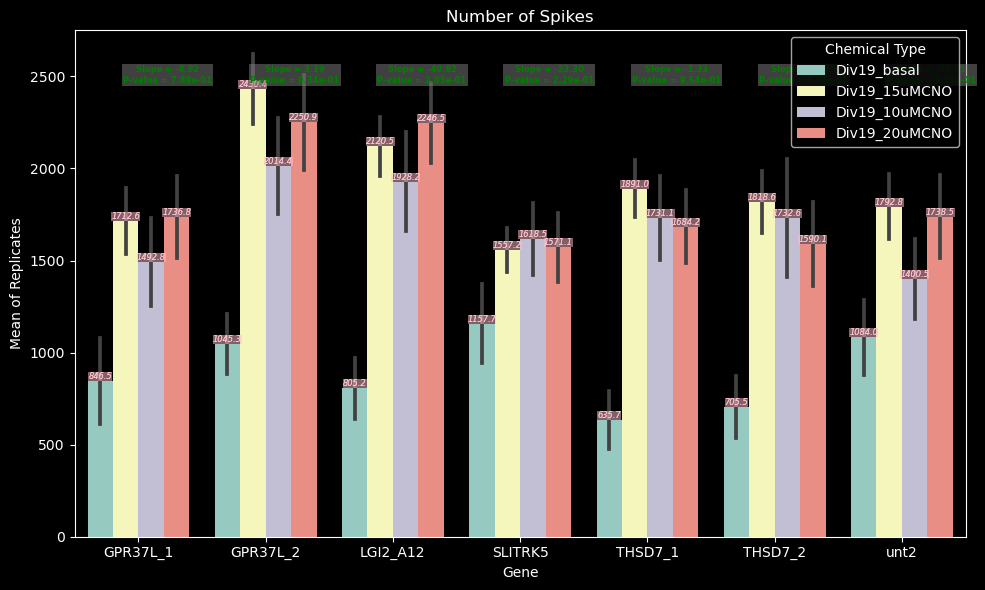

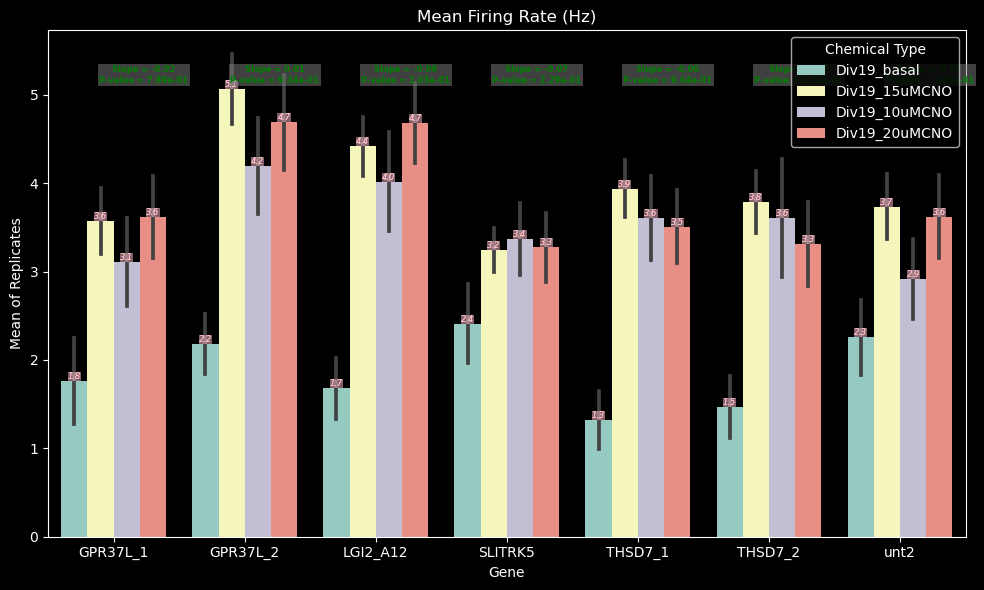

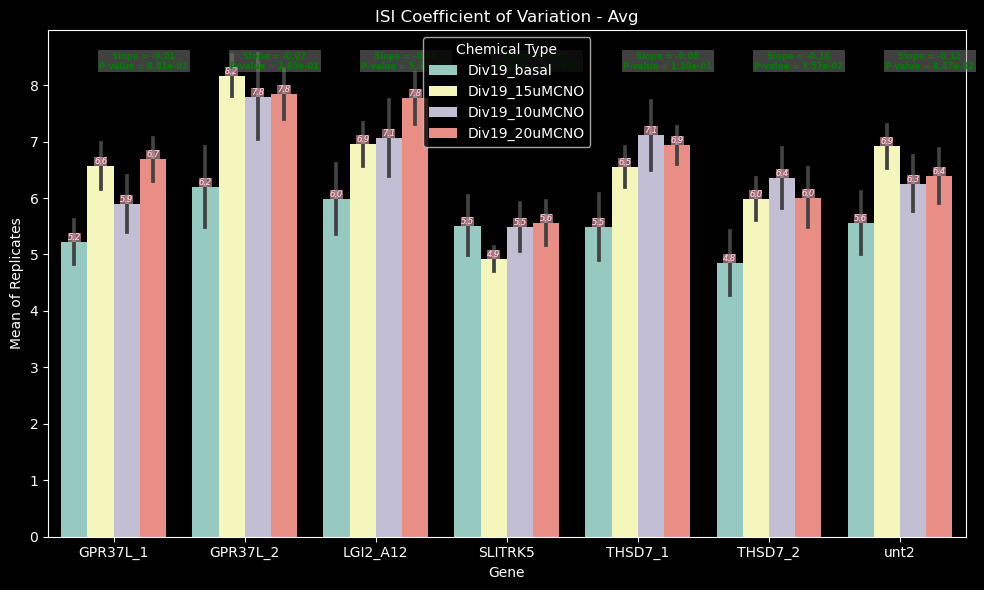

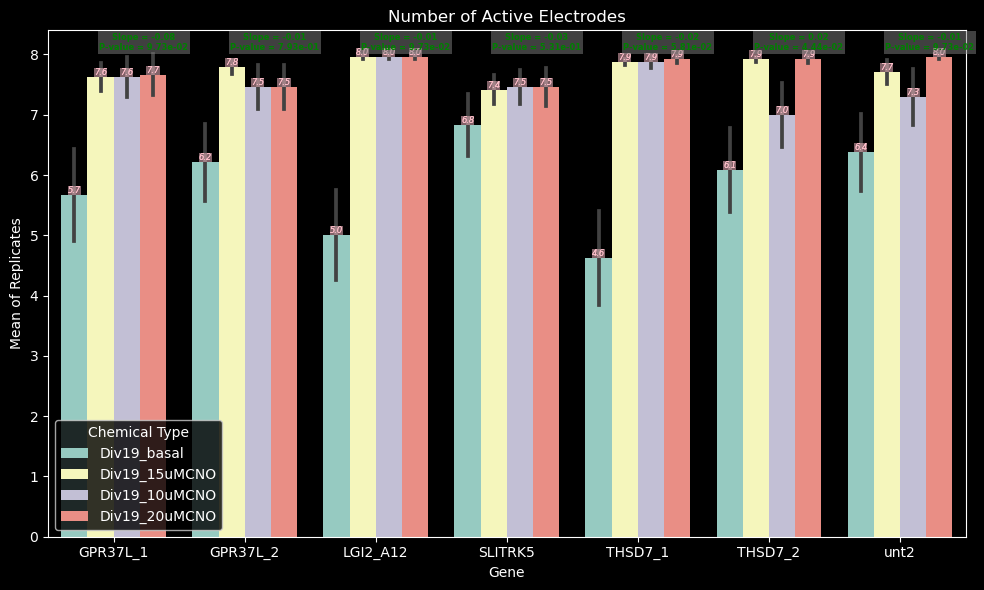

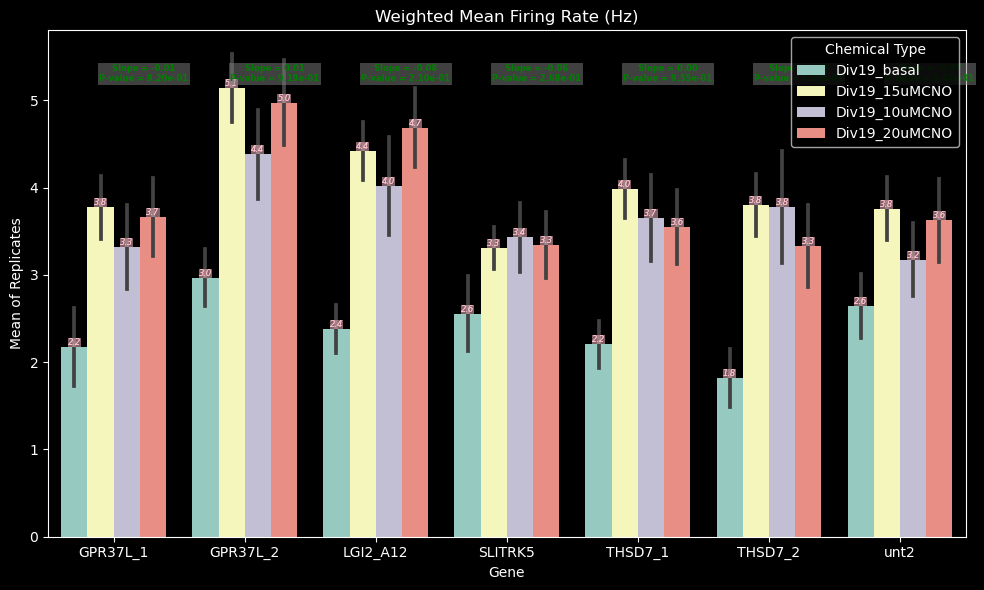

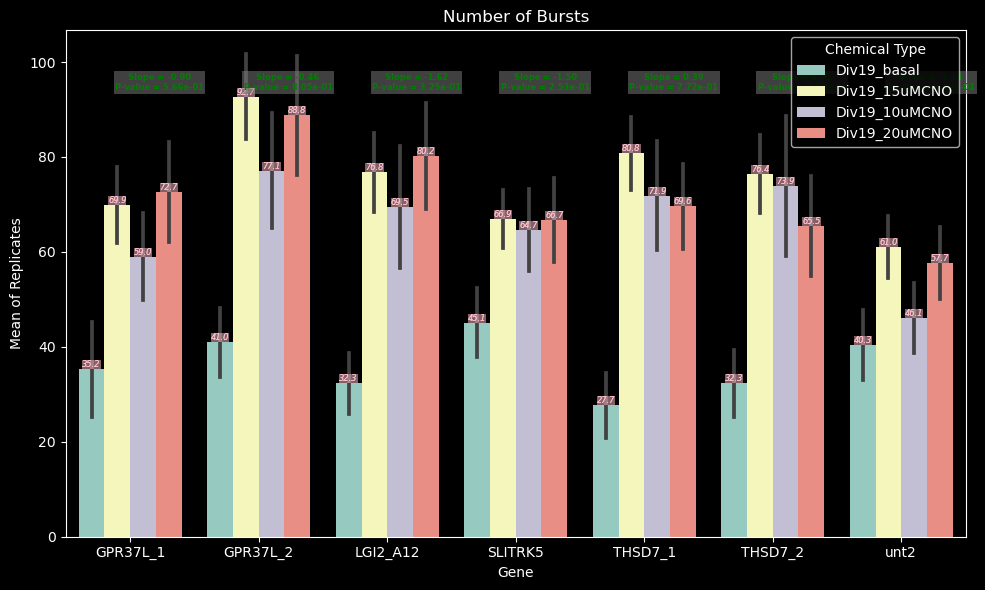

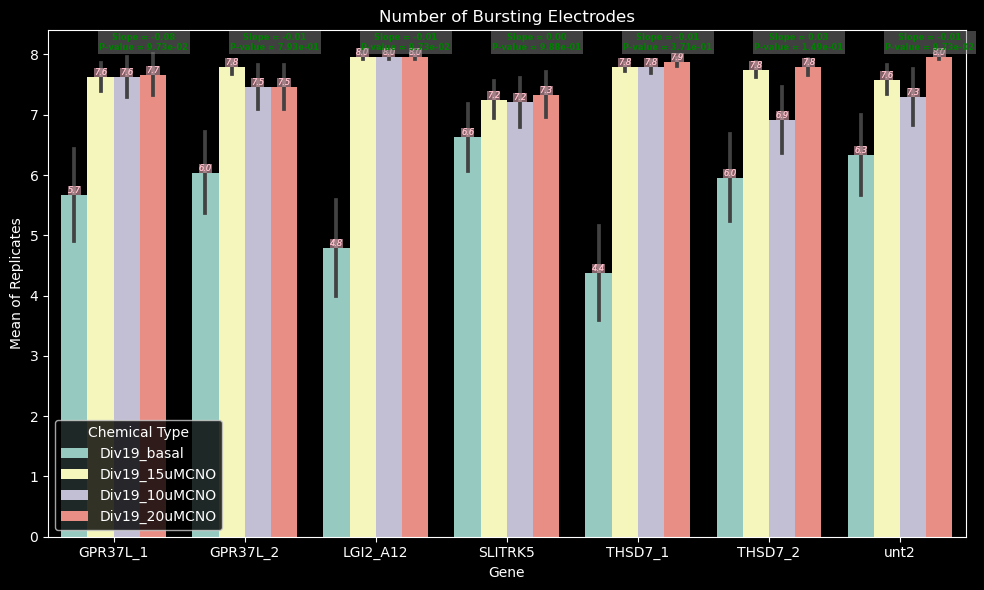

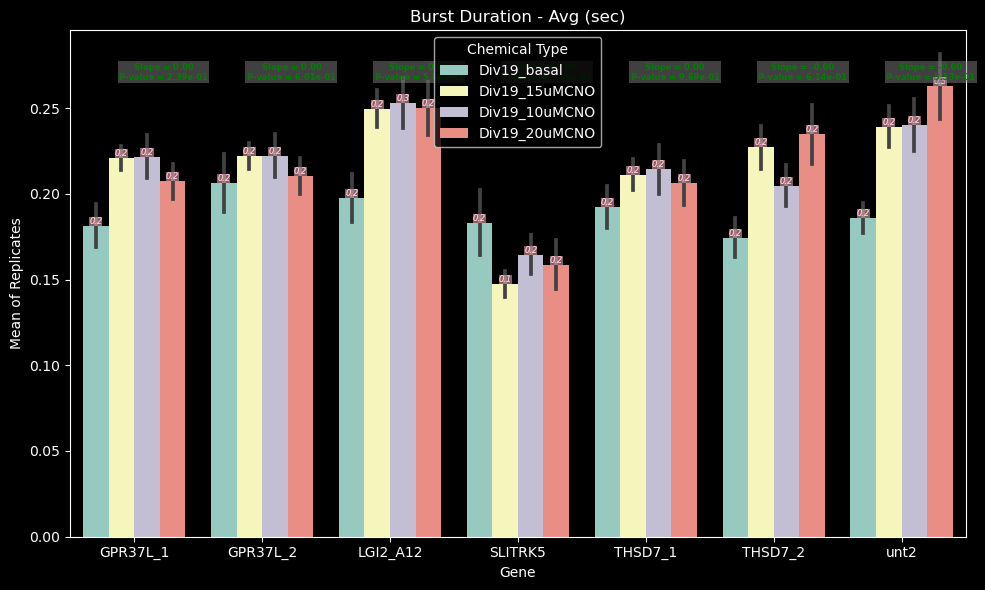

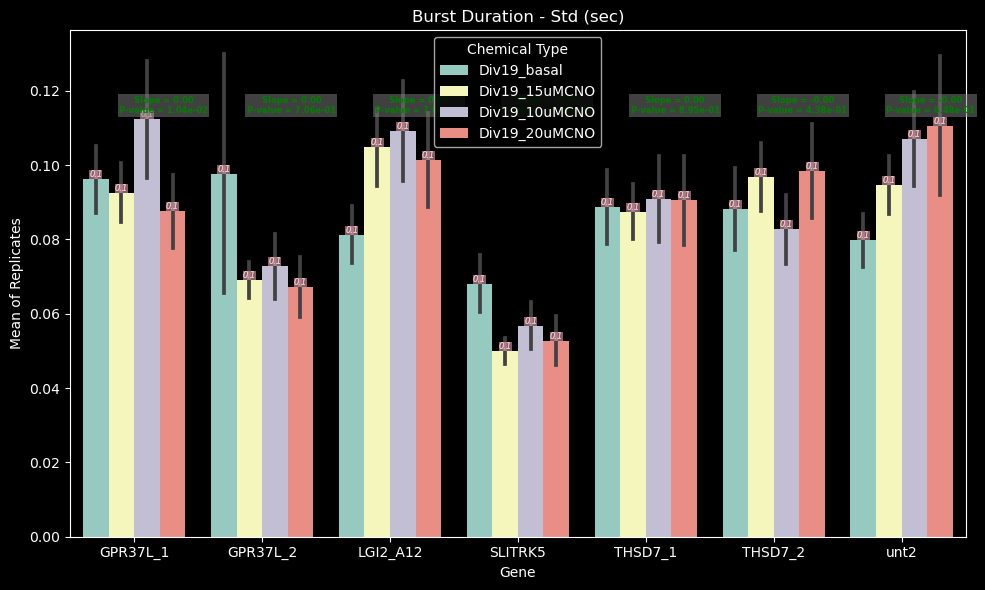

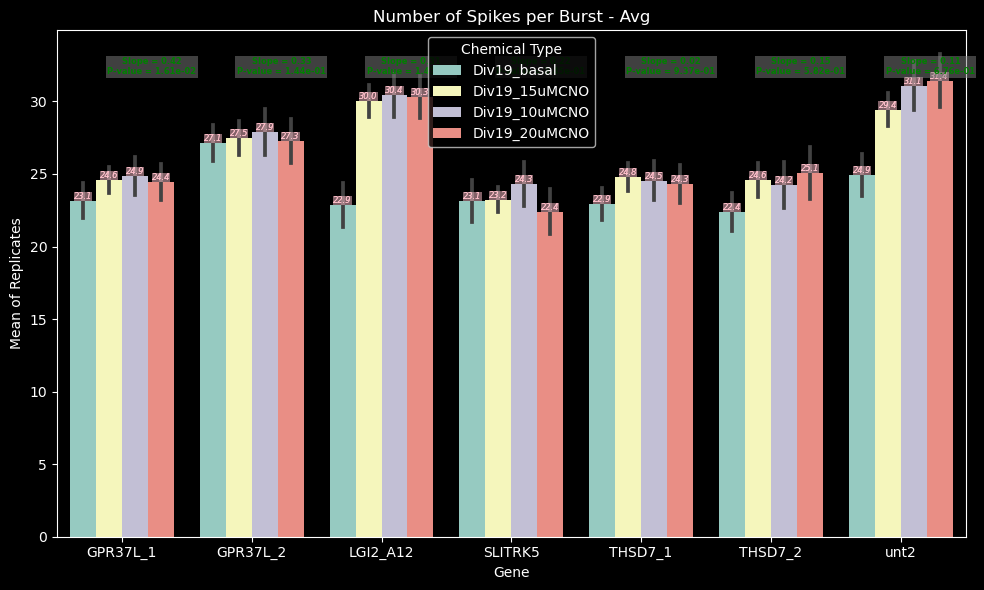

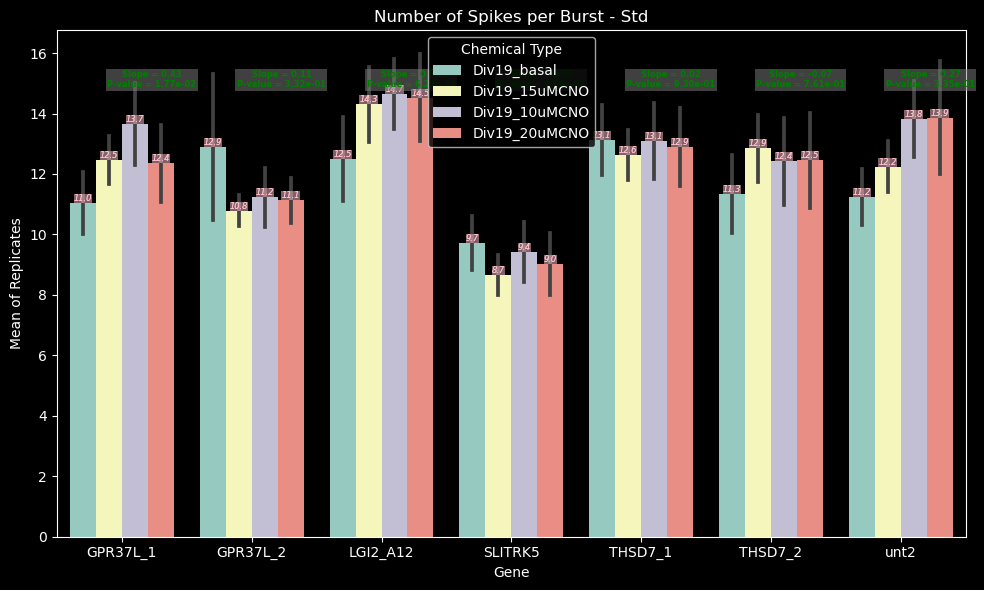

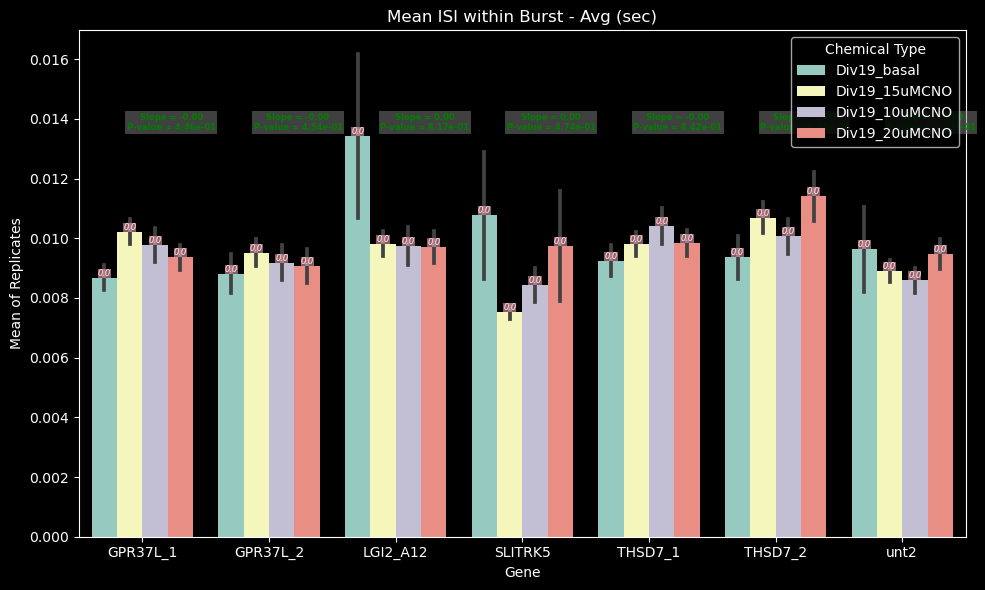

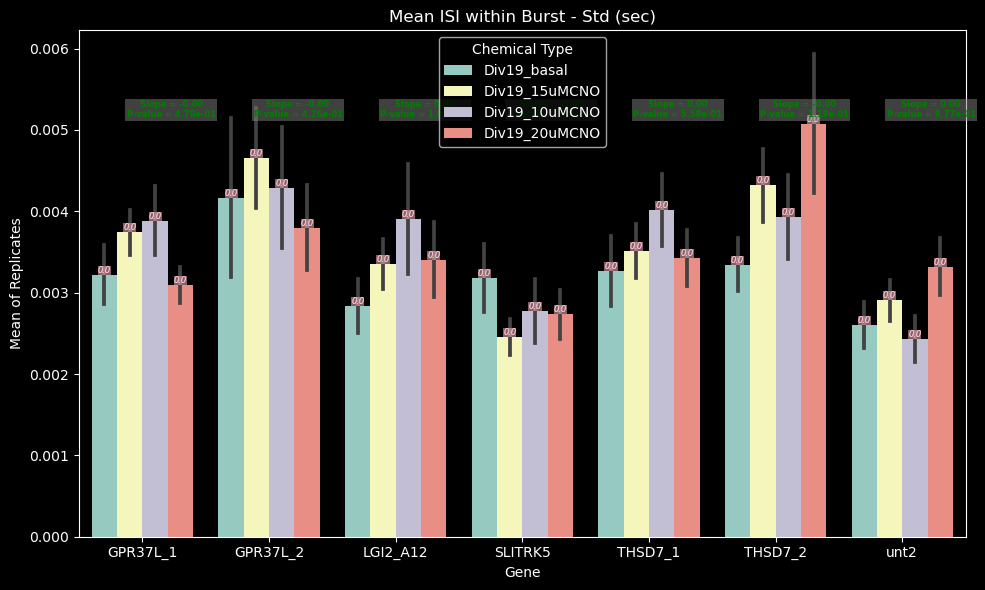

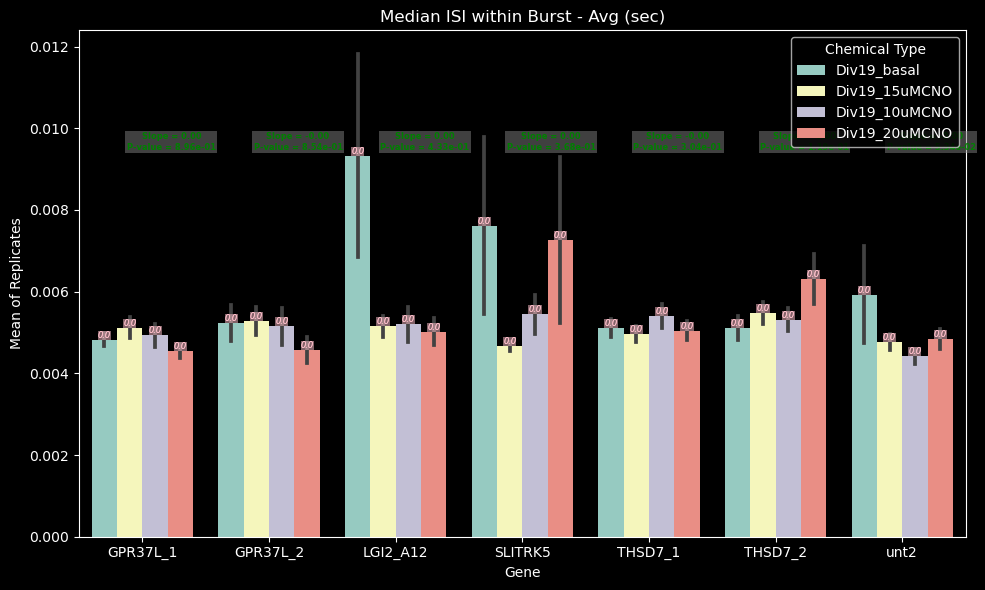

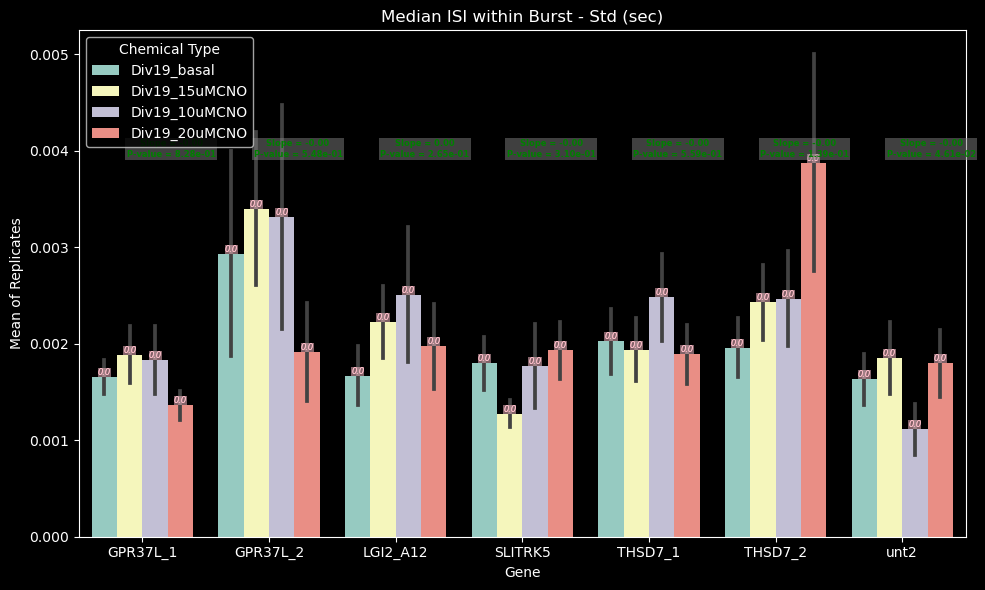

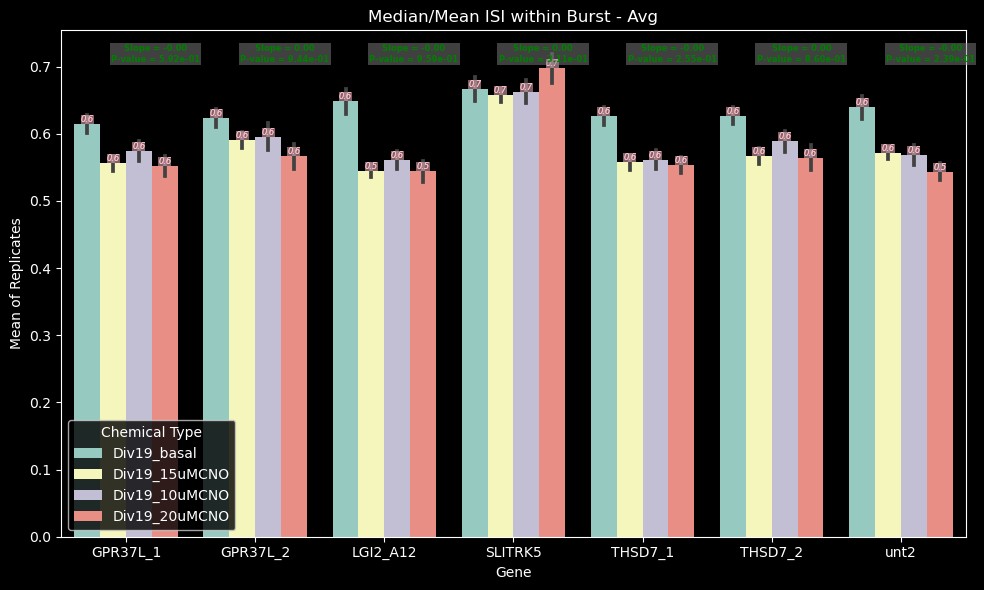

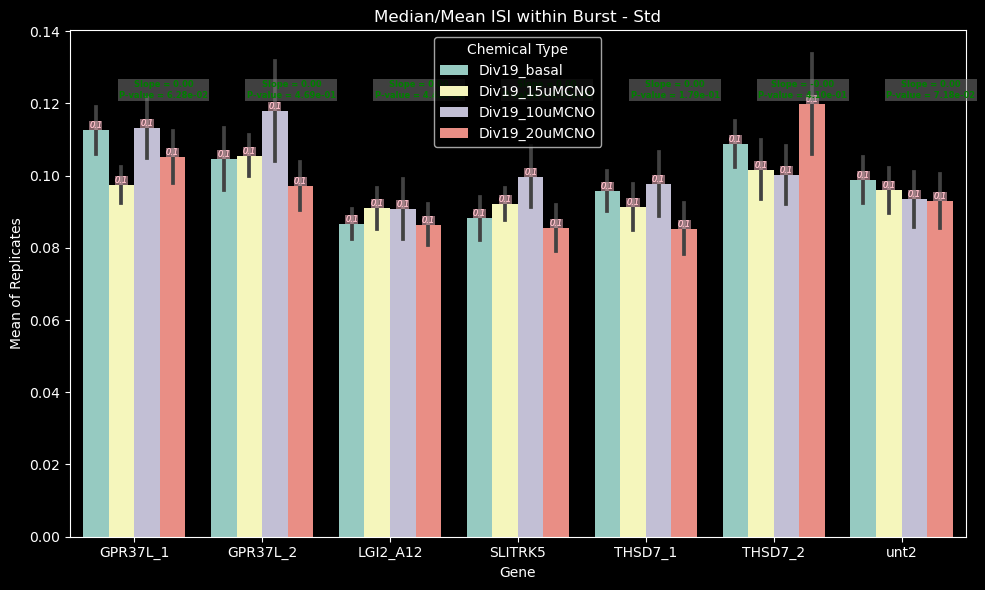

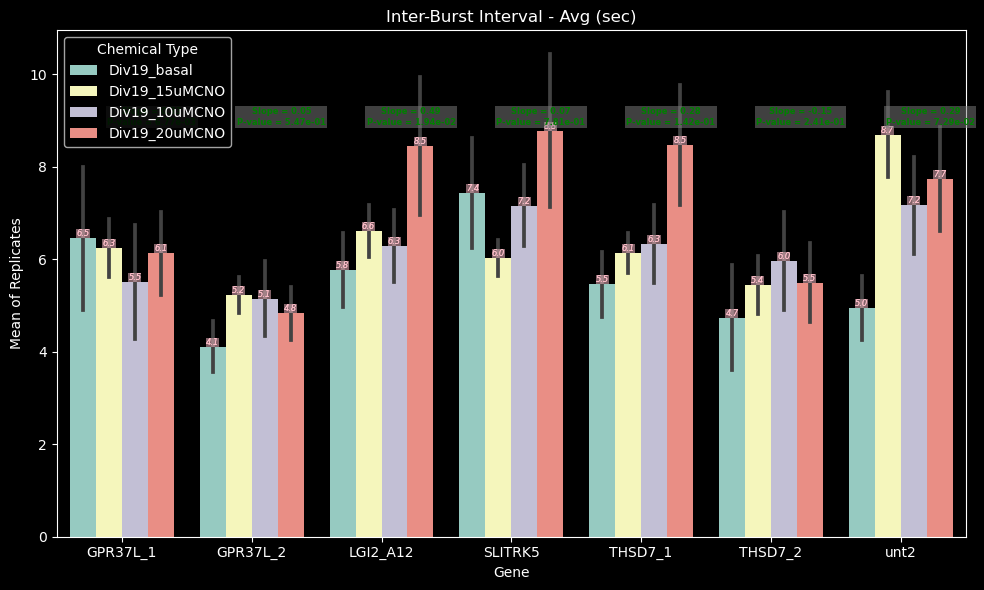

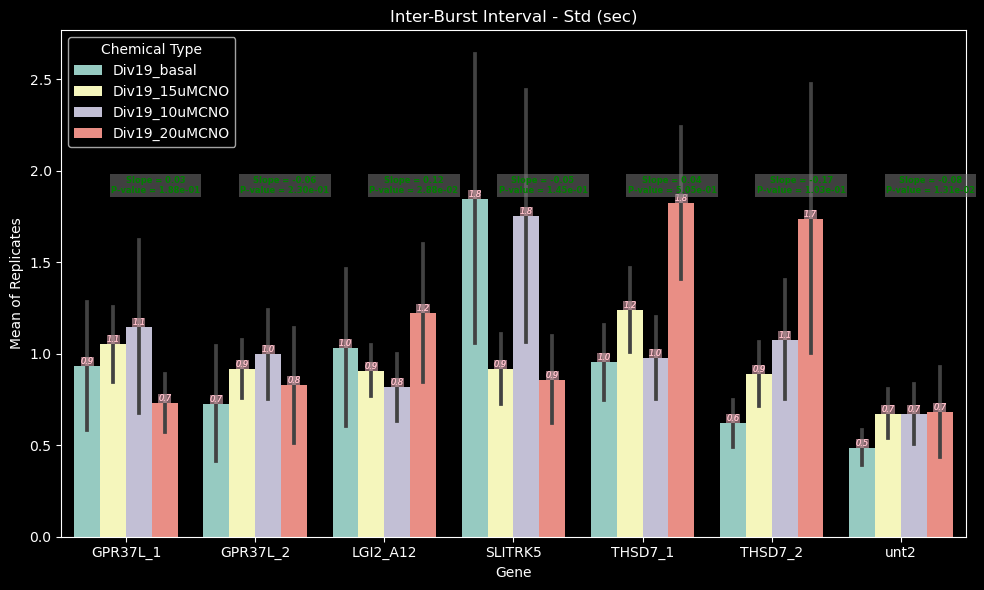

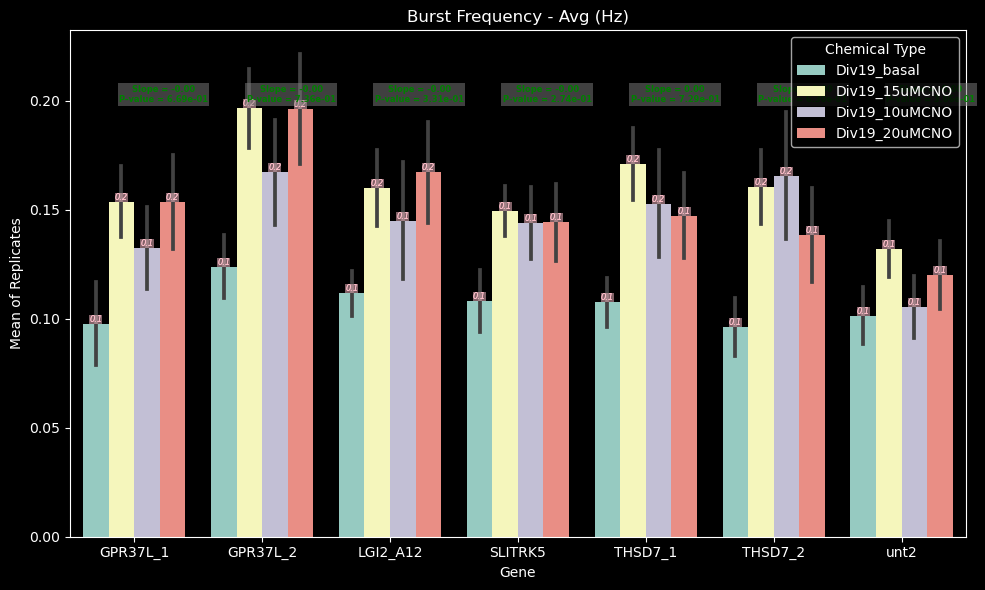

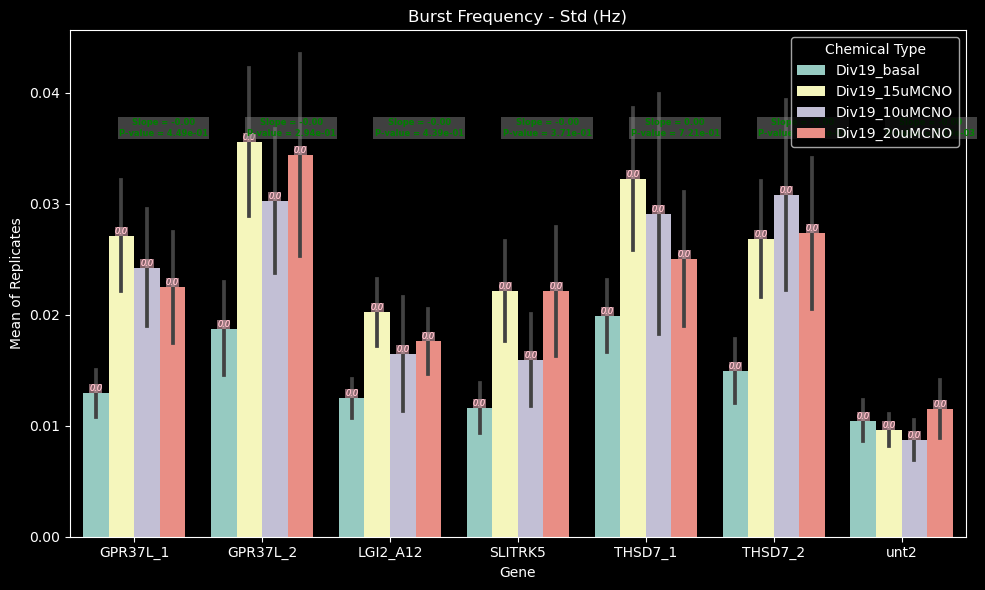

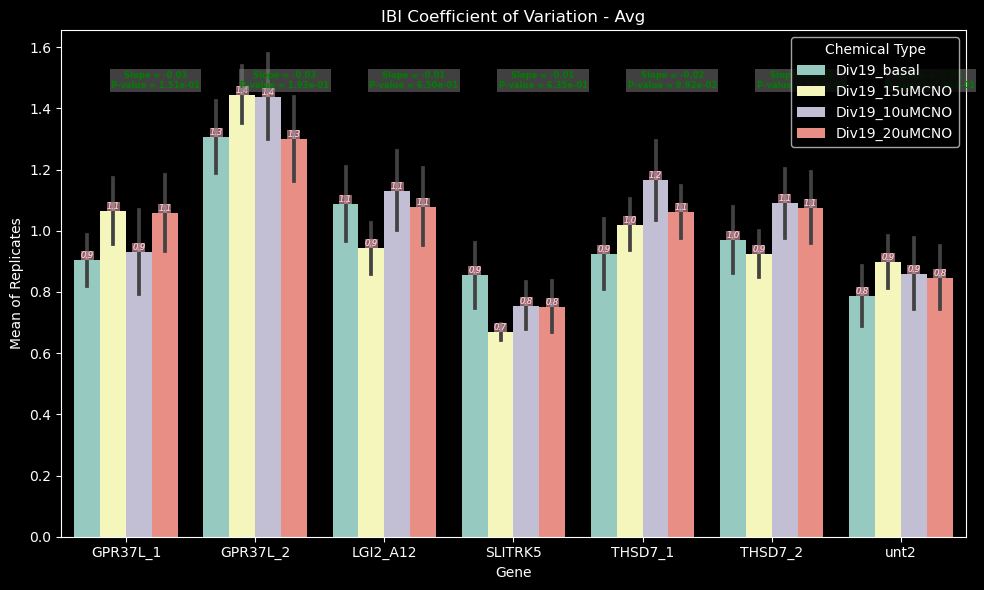

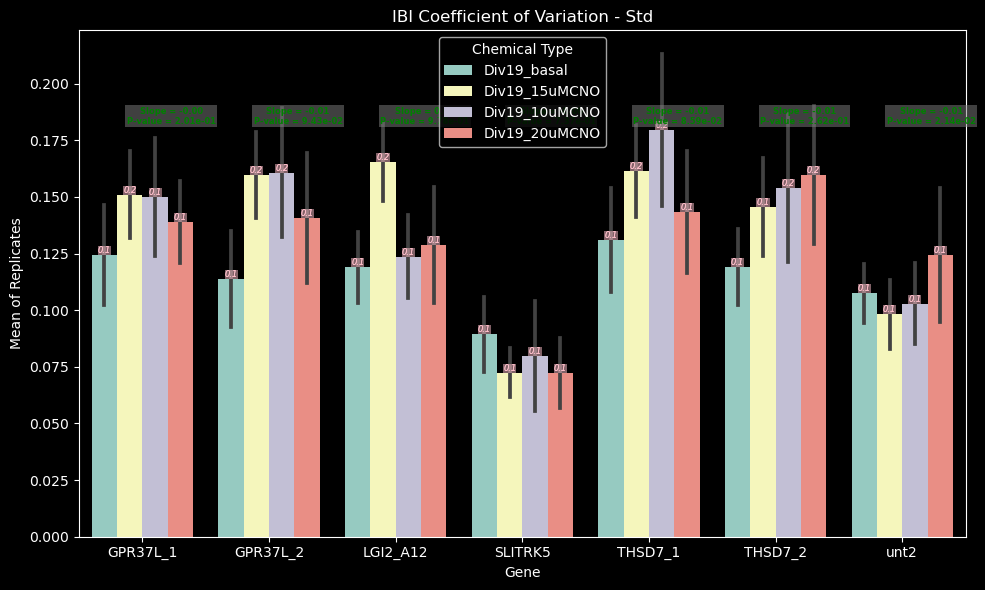

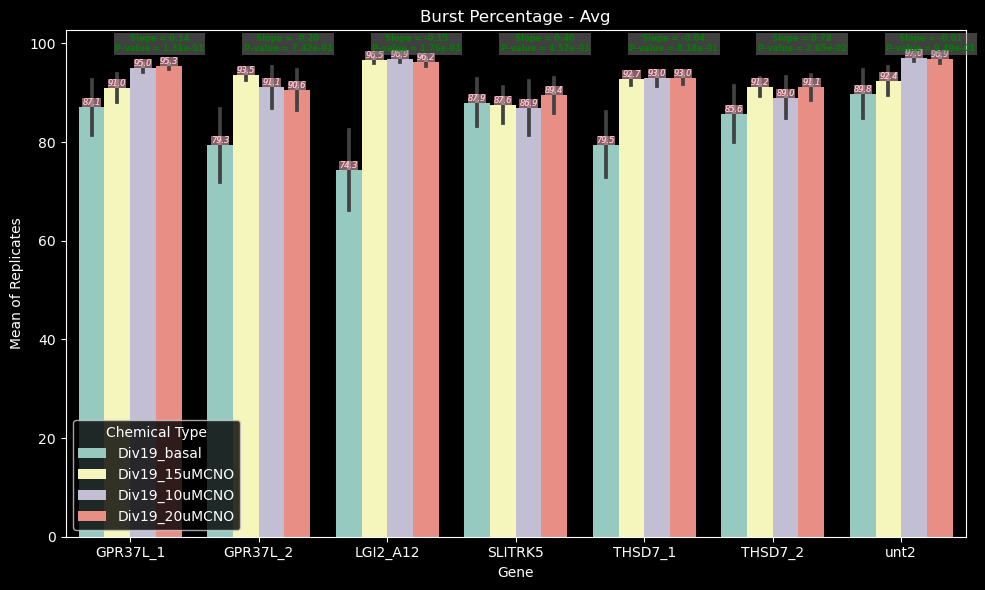

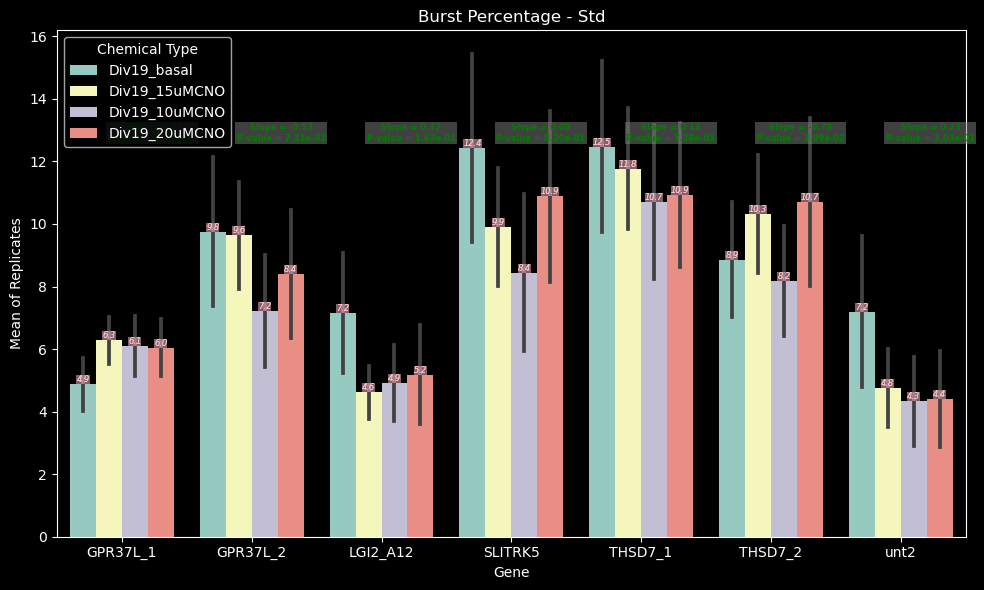

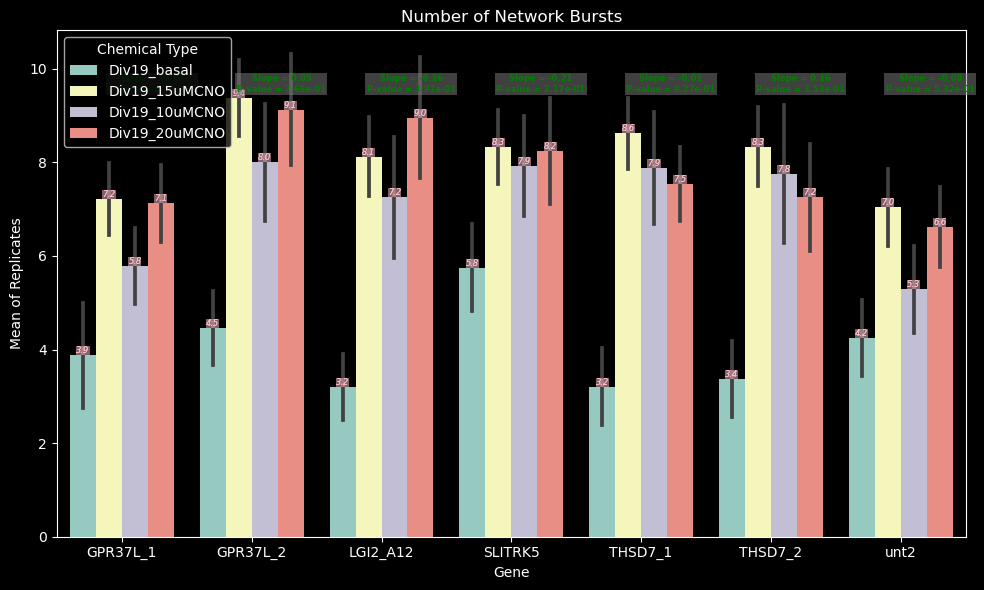

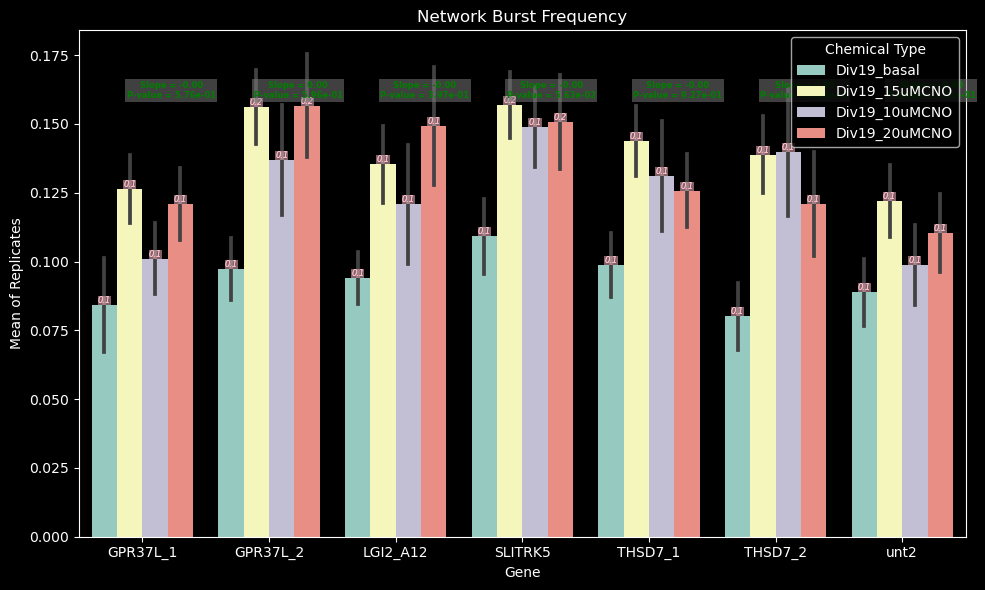

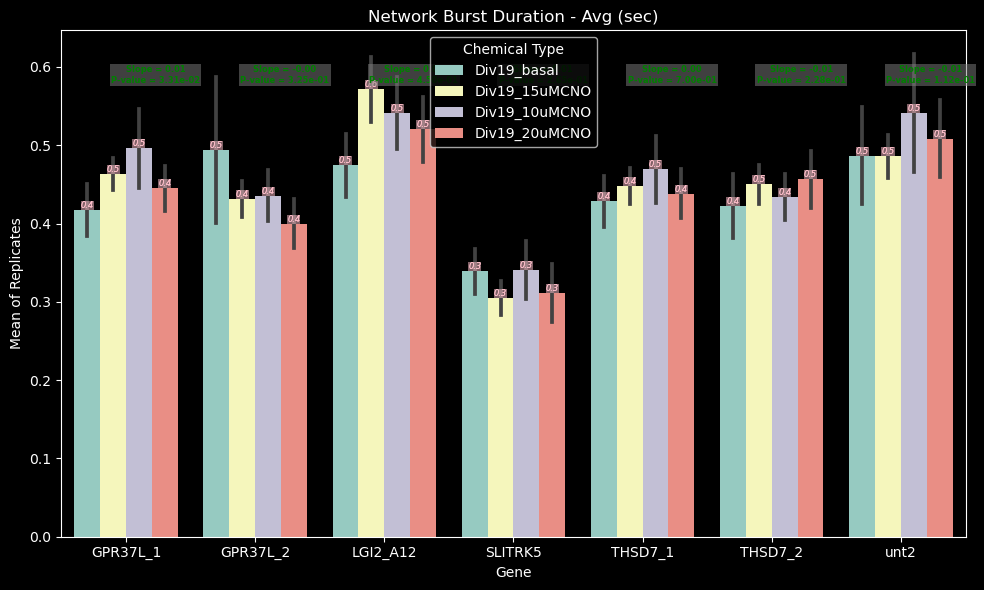

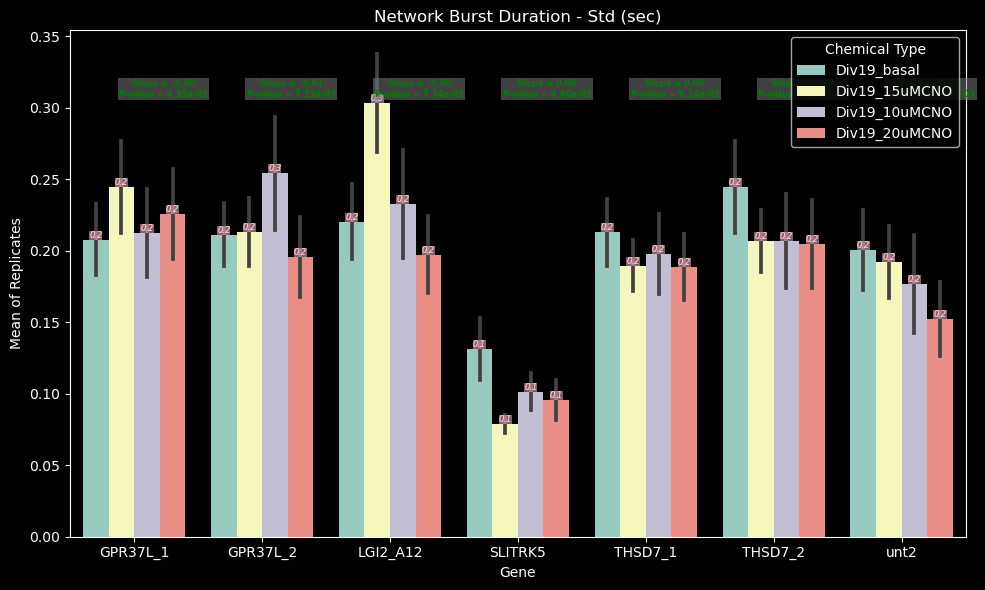

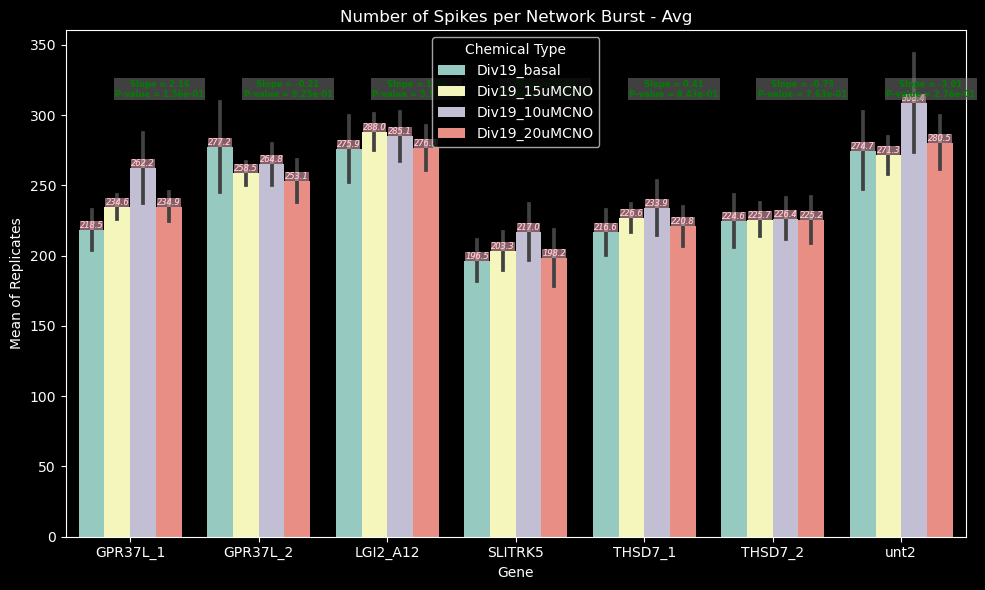

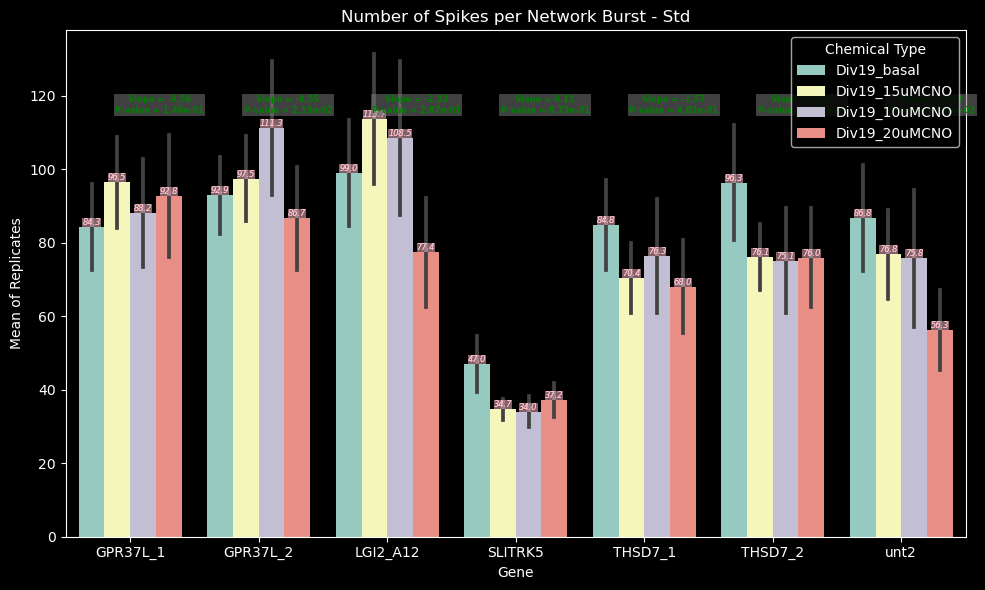

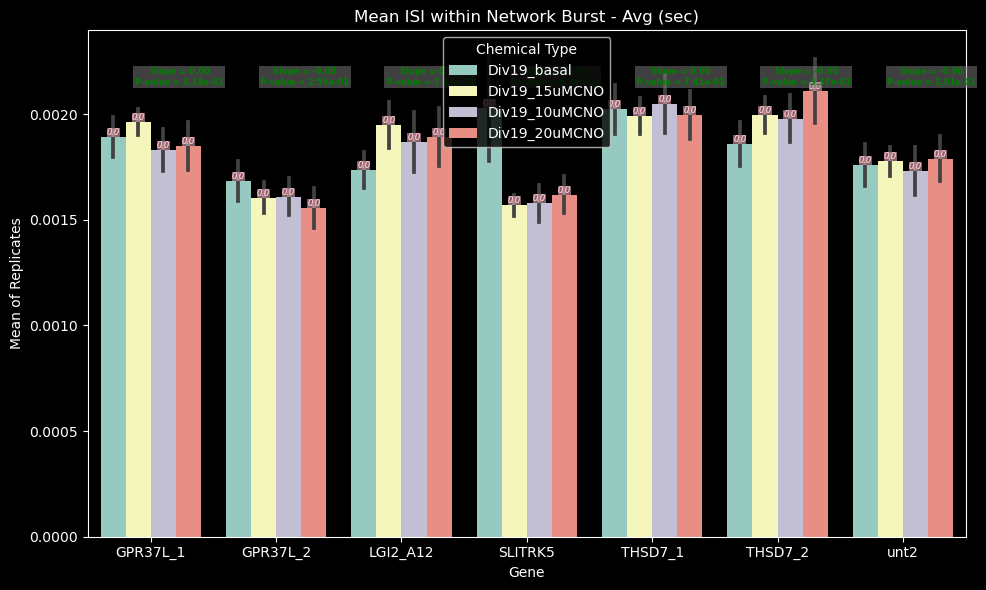

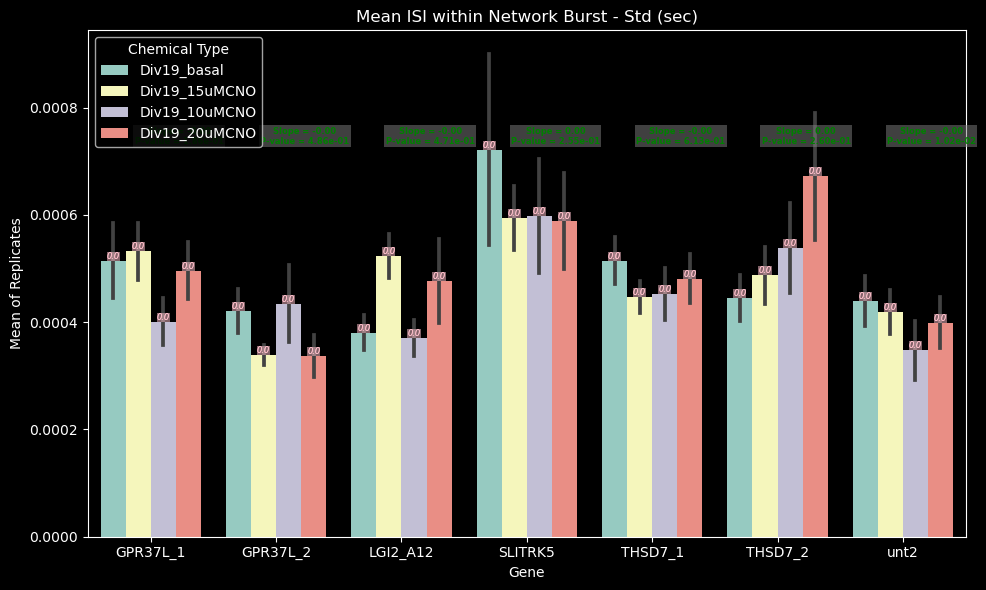

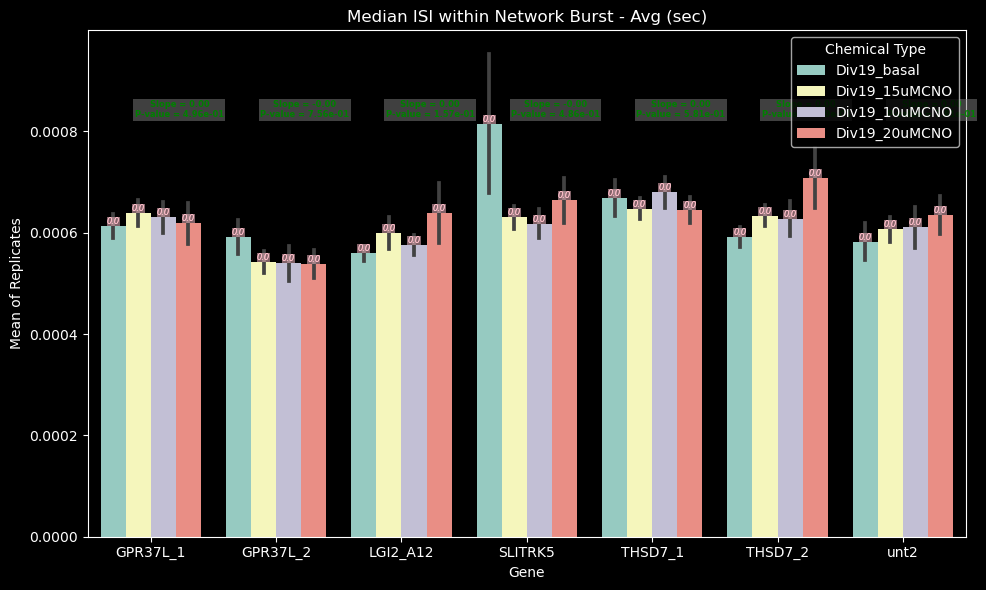

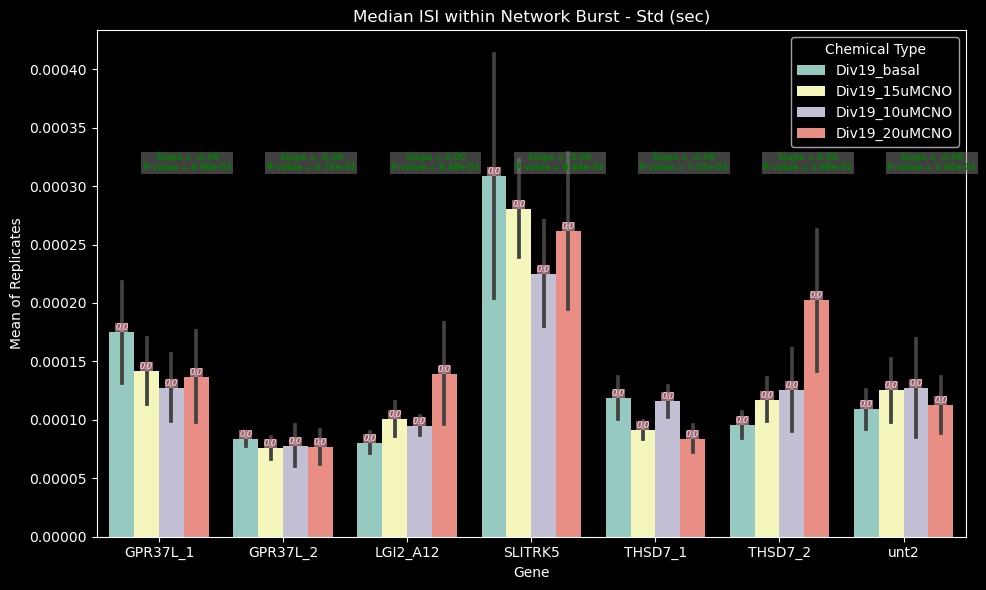

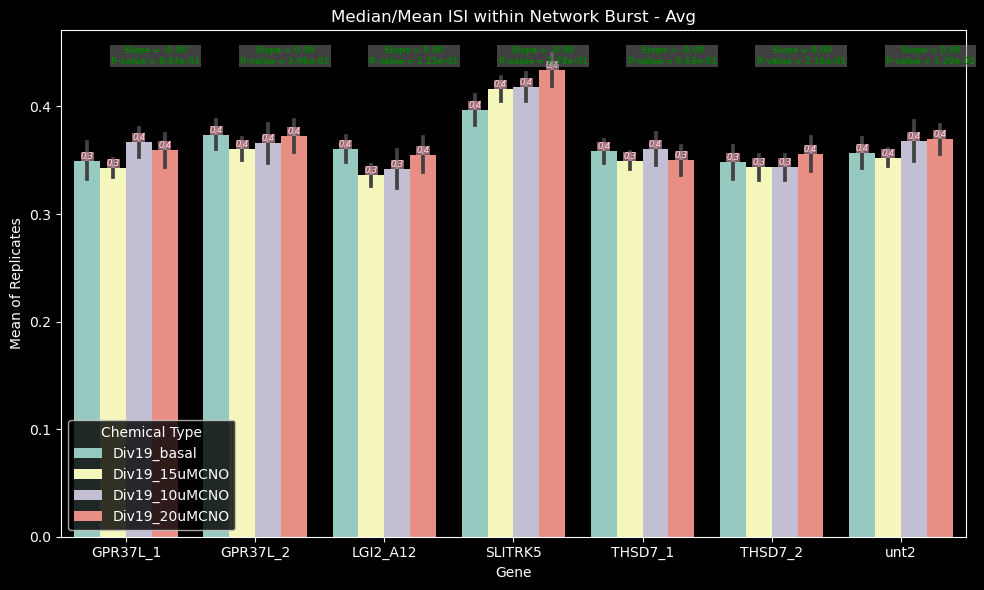

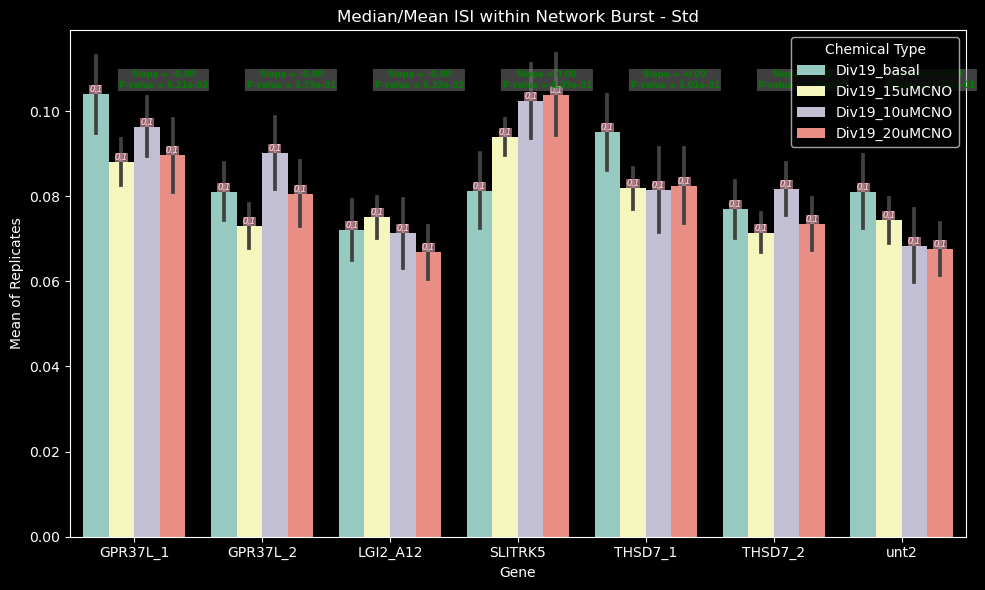

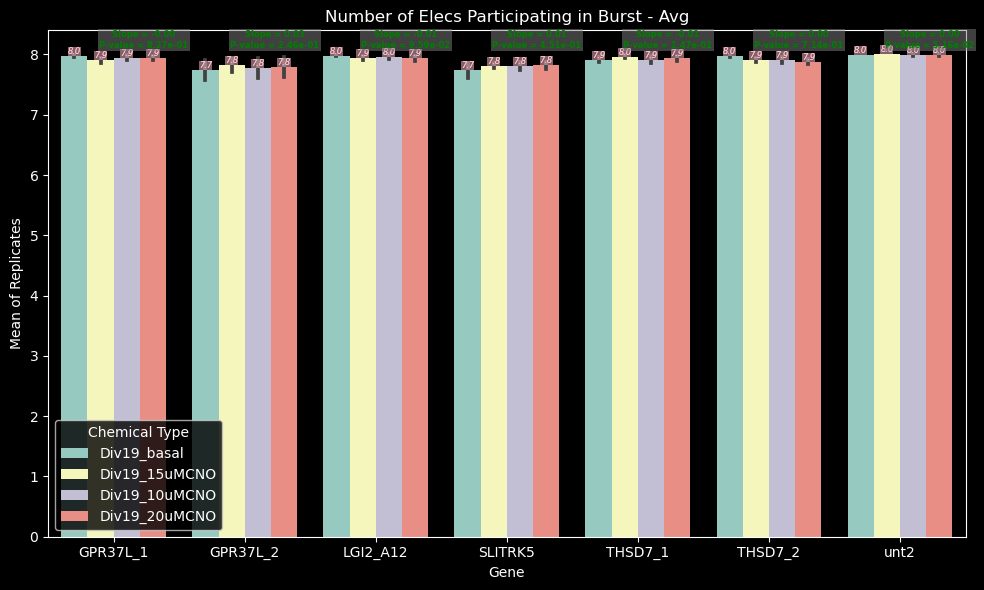

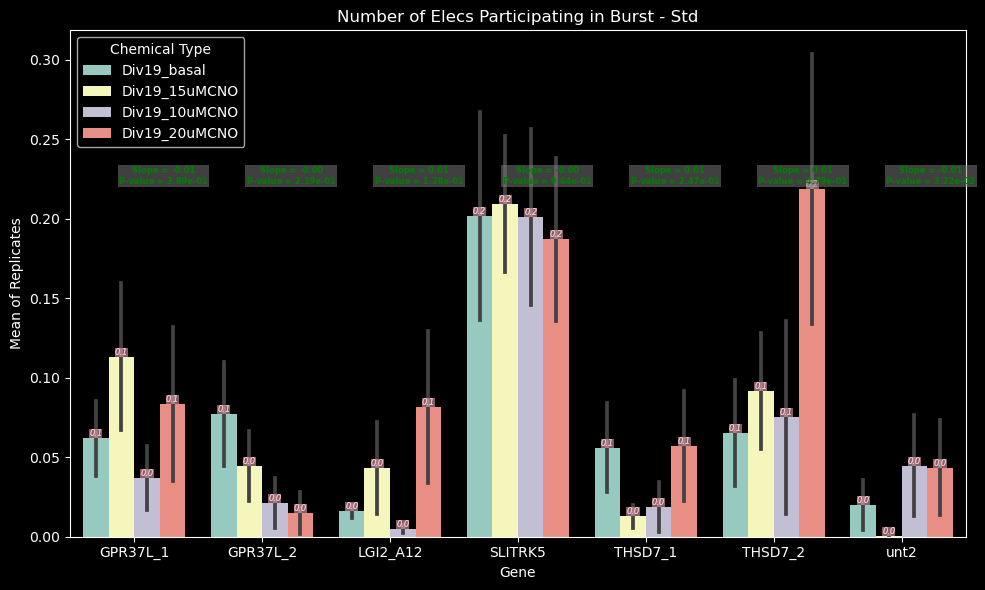

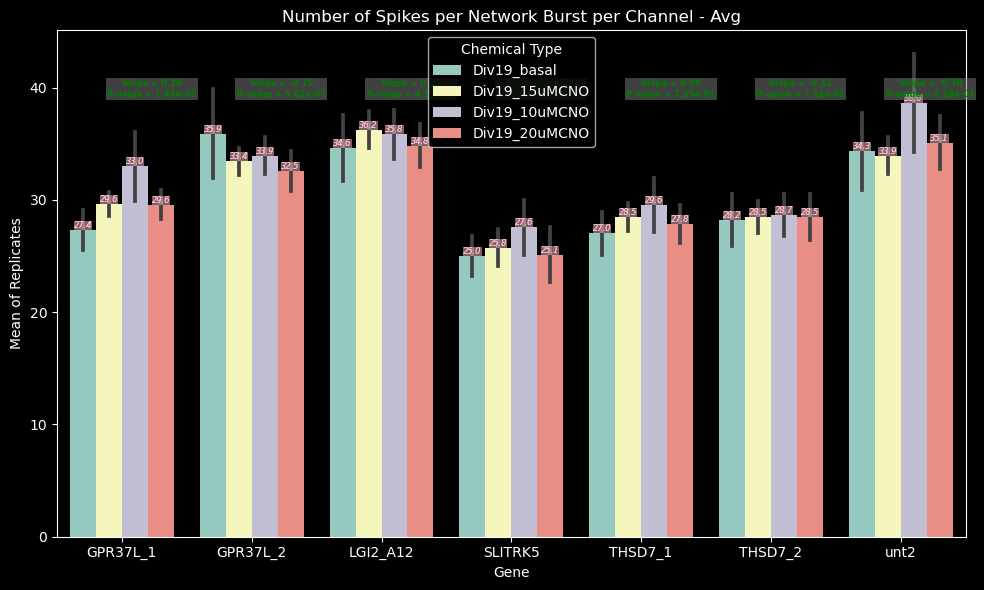

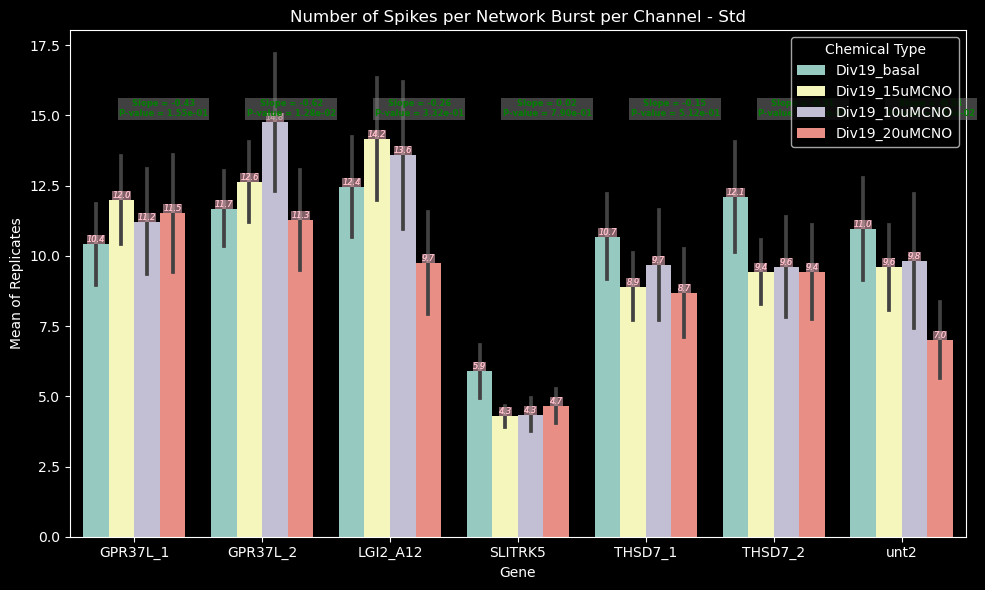

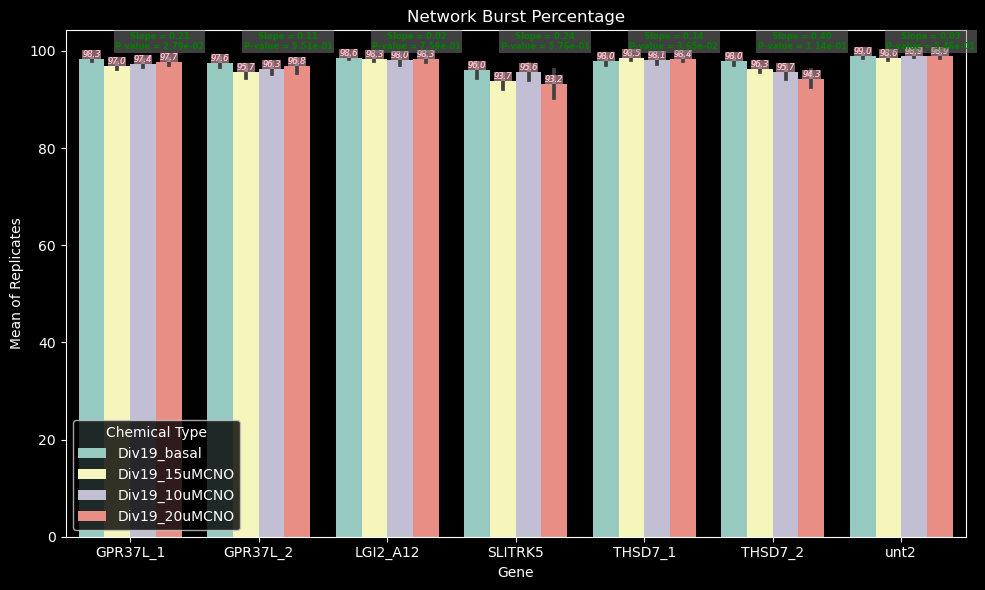

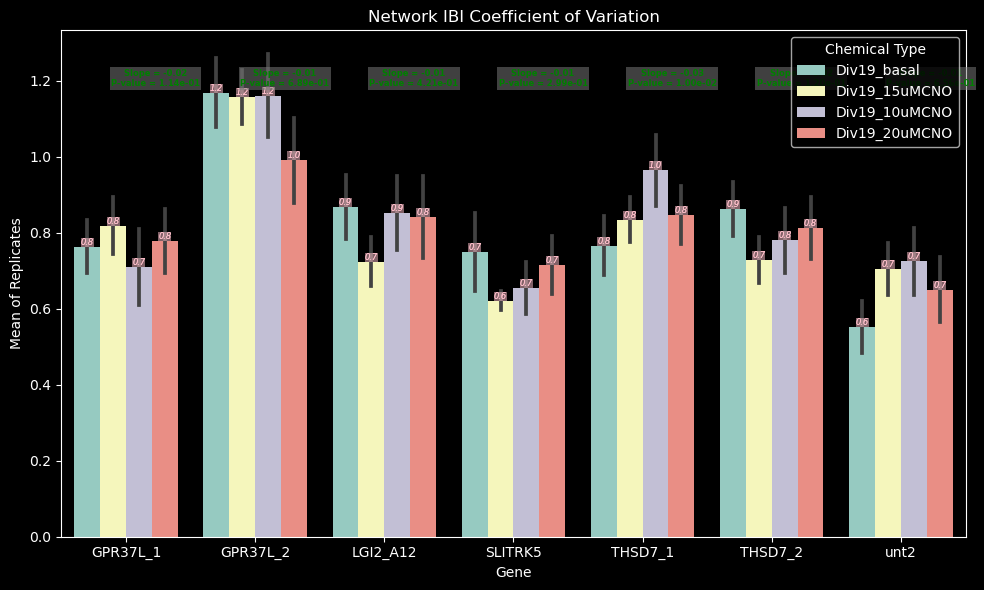

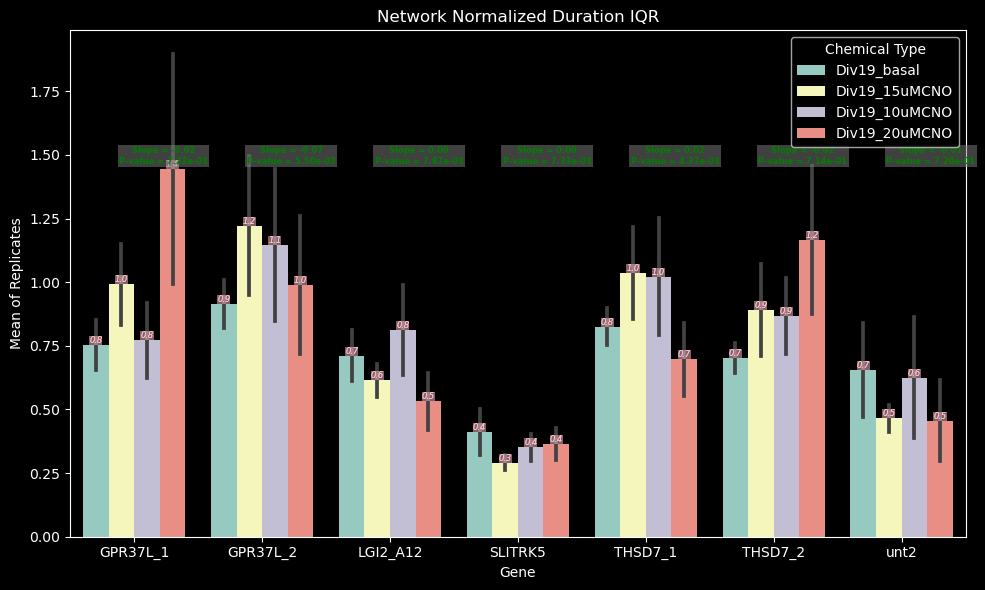

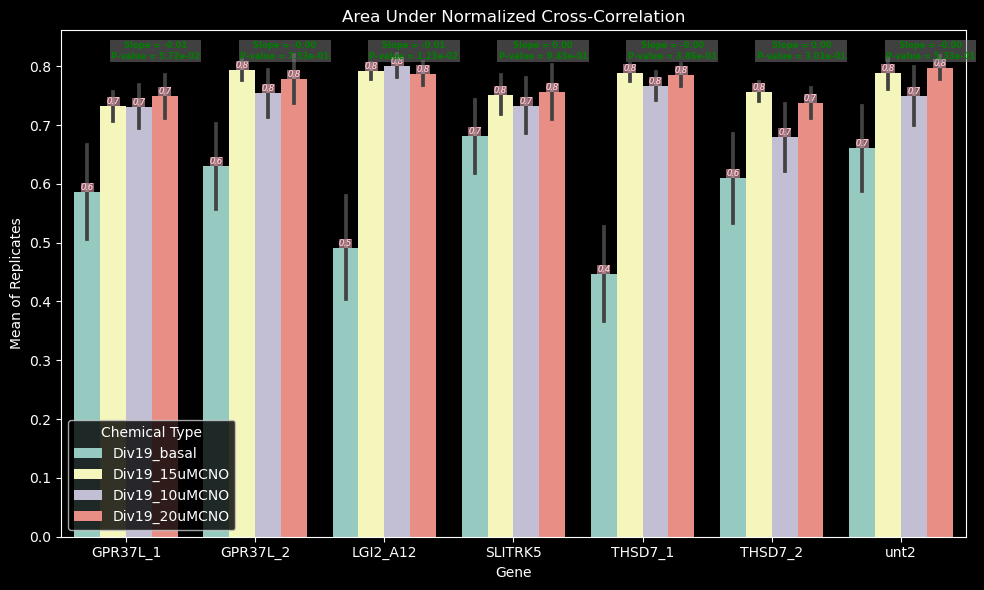

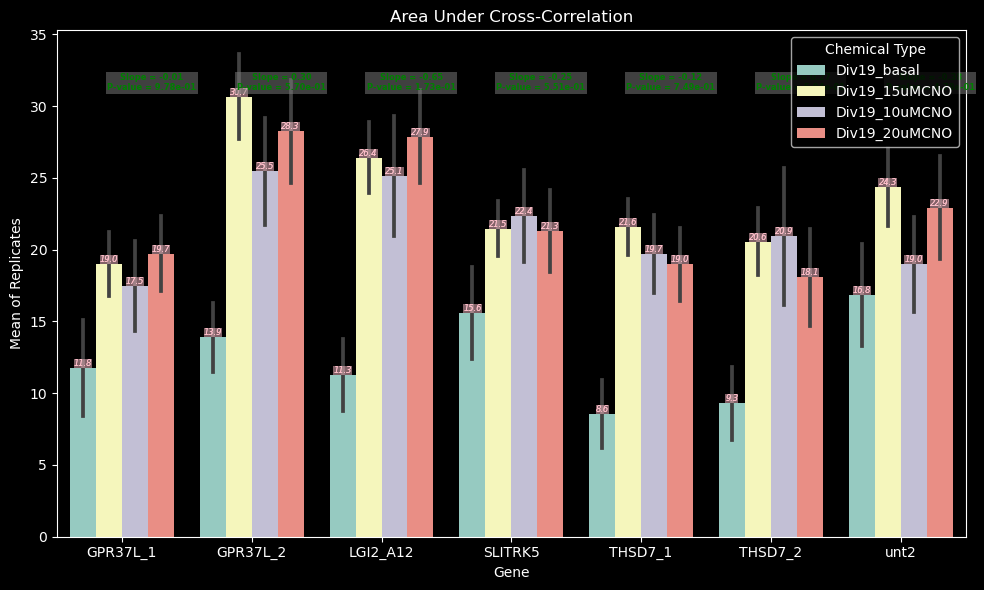

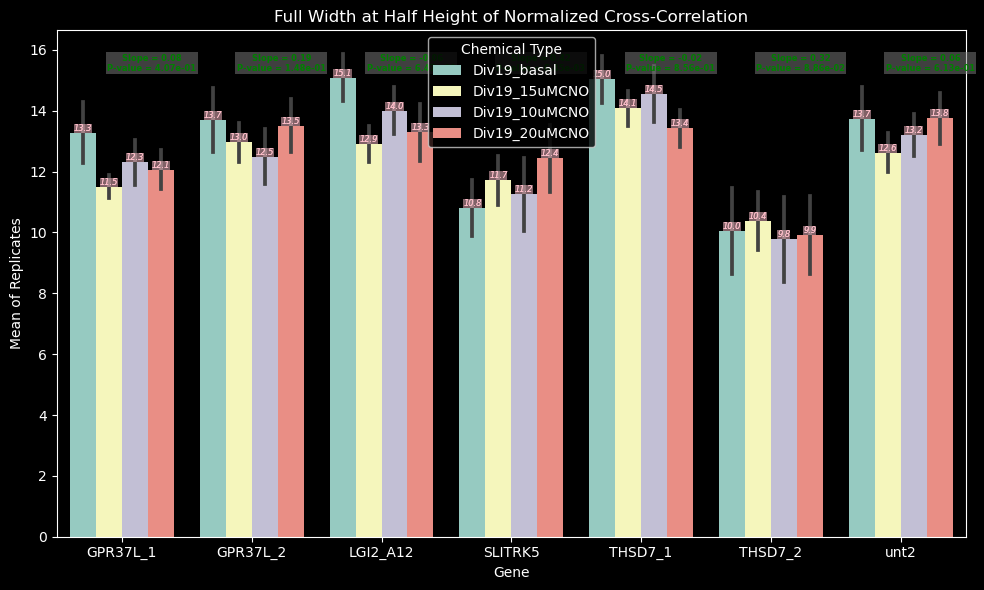

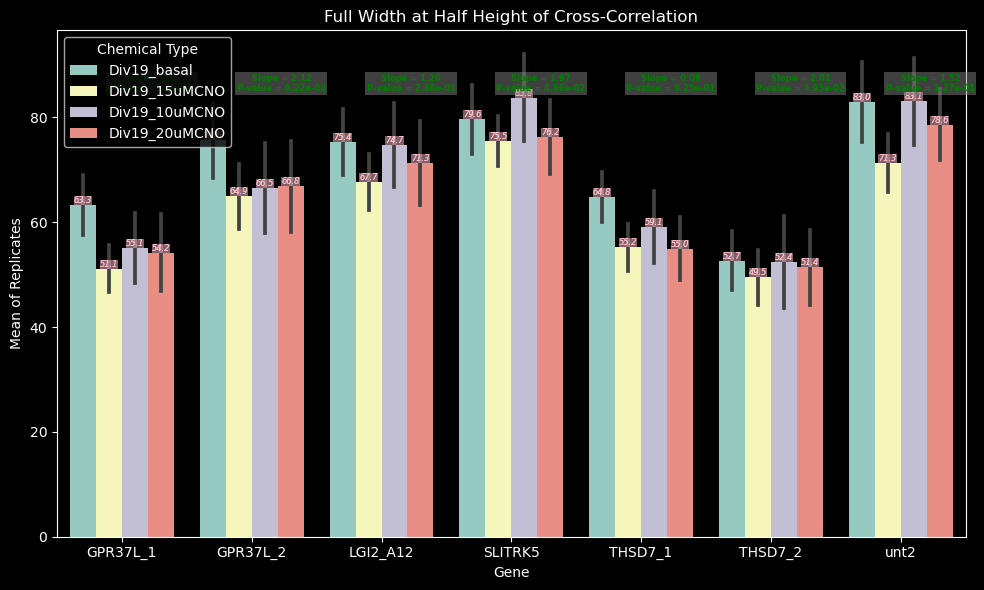

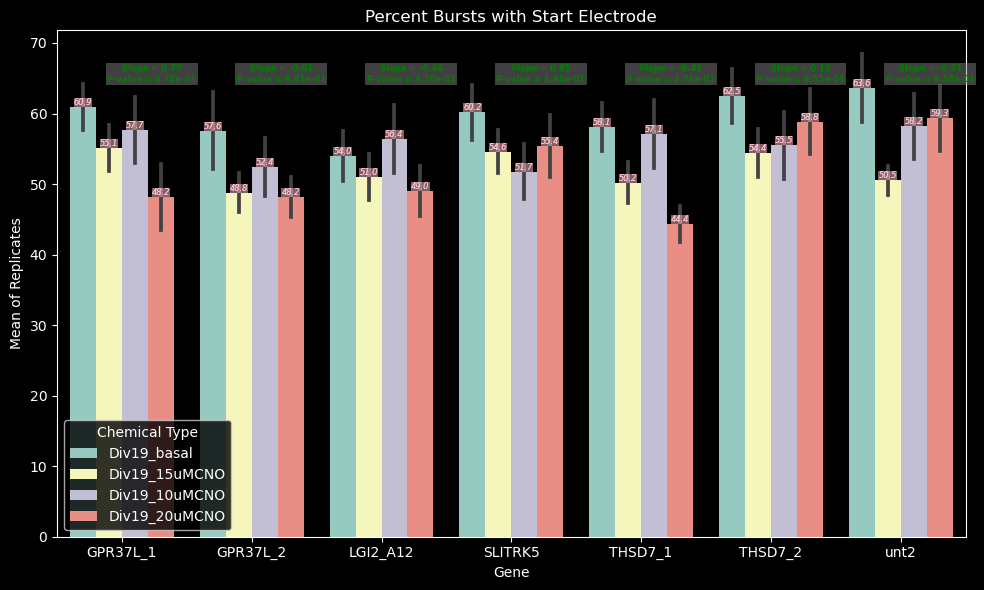

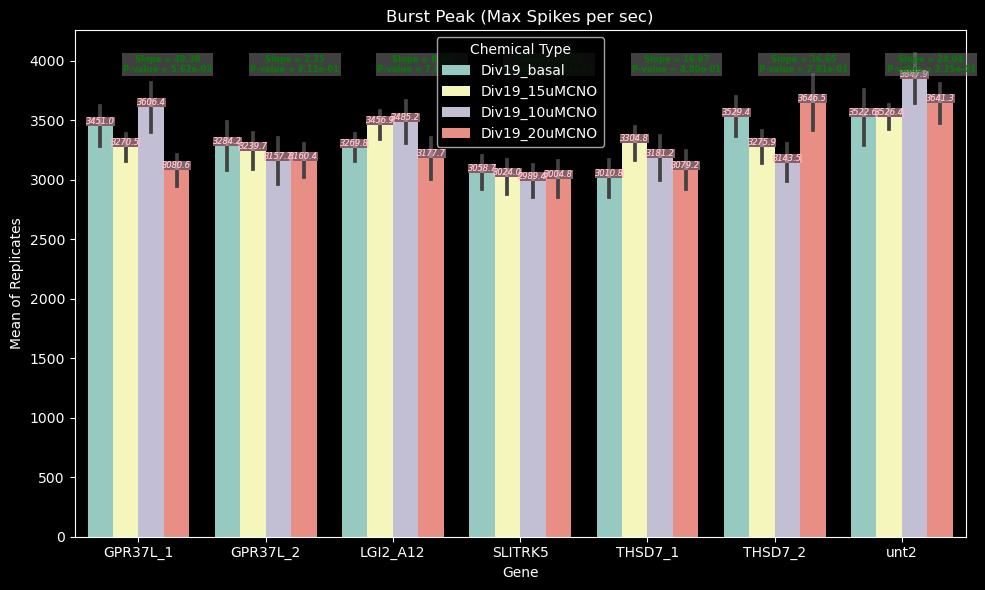

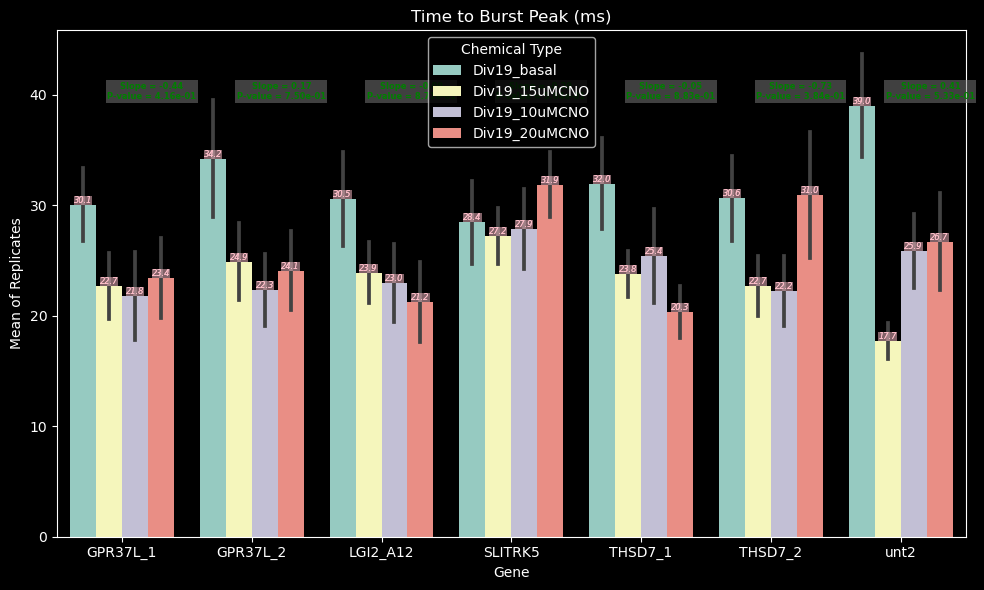

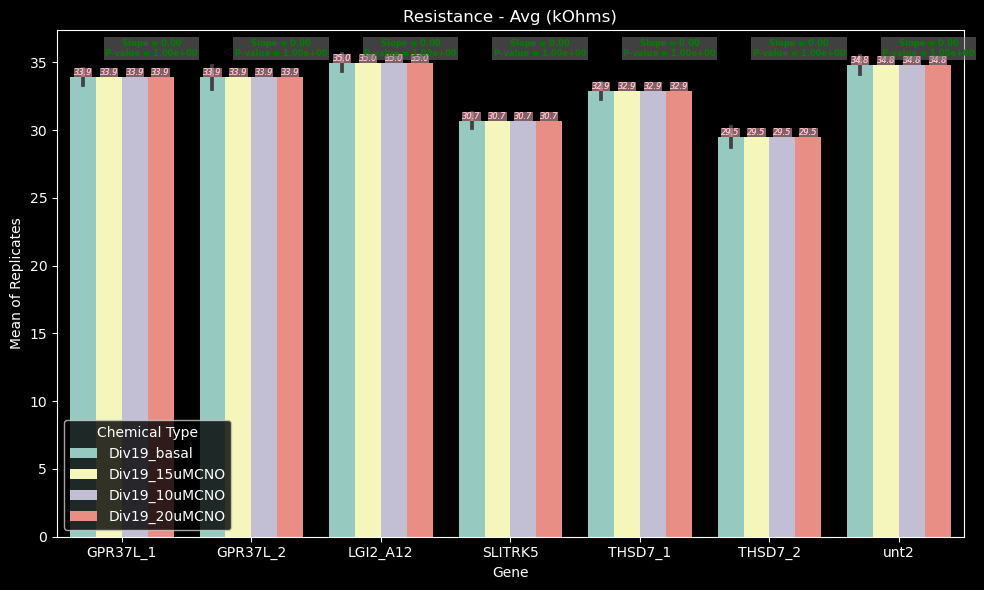

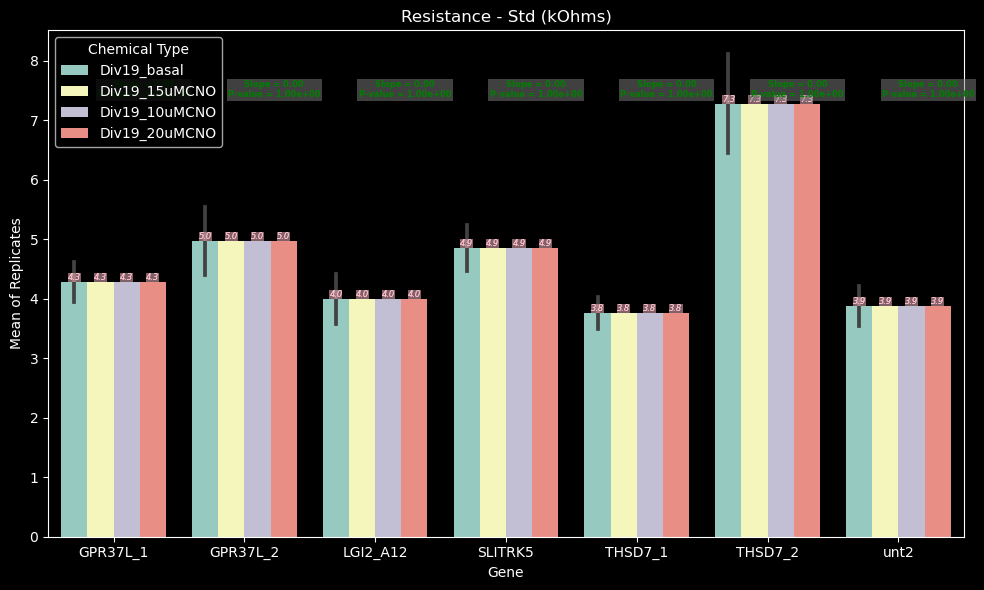

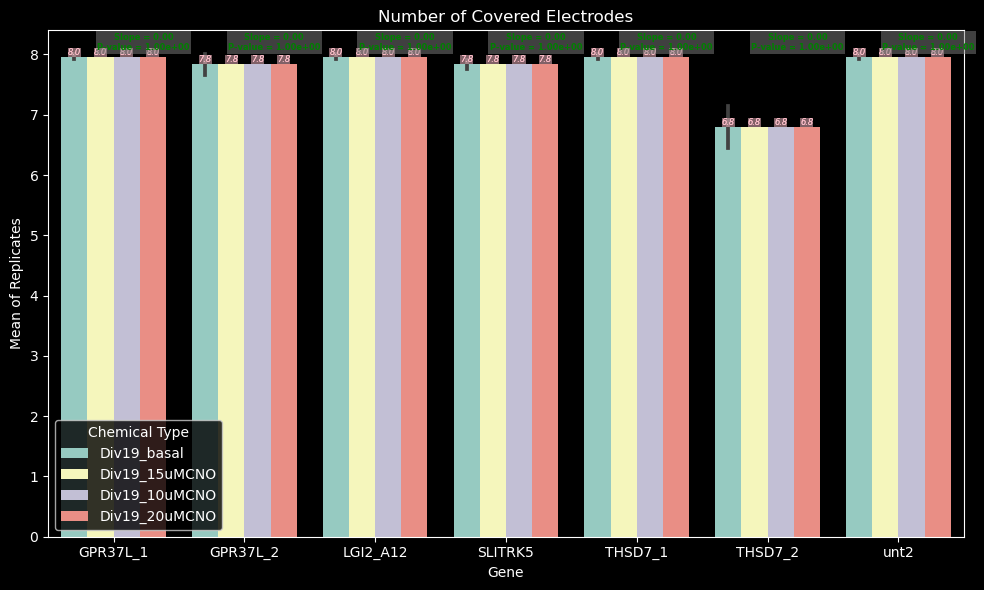

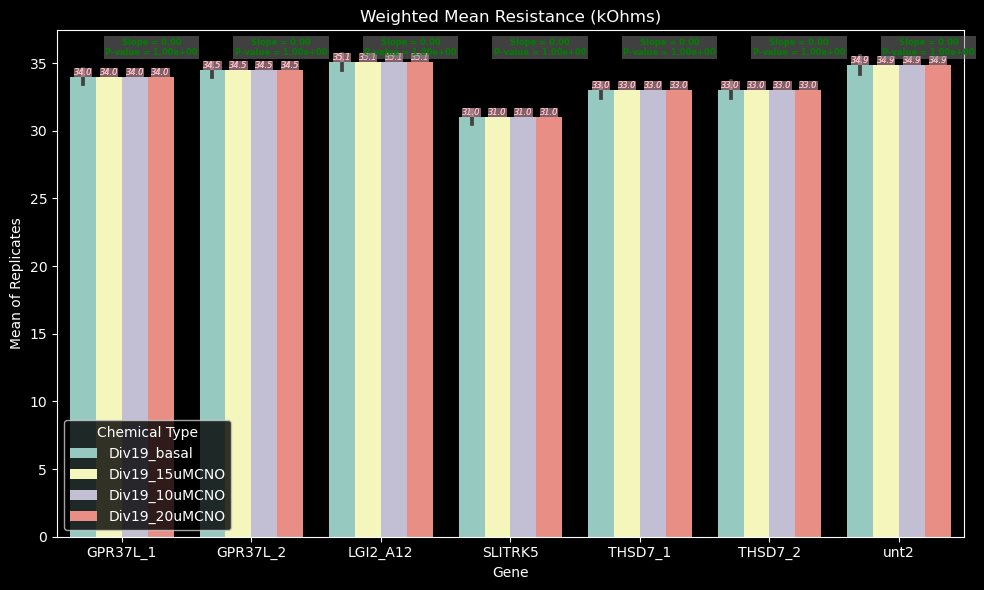

In [28]:
def create_bar_chart(testparameter, df, show_barlabels = True, control_var="unt2"):
    bar_width=0.20
    plt.figure(figsize=(10, 6)) # Adjust the size as needed
    # Create a bar plot
    ax = sns.barplot(x='Gene', y='Value', hue='Chemical_Type', data=df, errorbar='se')

    plt.title(f"{testparameter}")
    plt.xlabel('Gene')
    plt.ylabel('Mean of Replicates')
    plt.legend(title='Chemical Type')
    if show_barlabels:
        add_barlabels(ax)
    gene_slope_dict = compute_slope(df)
    if show_barlabels:
        add_barlabels(ax)  # This function needs to be defined elsewhere
    add_slope_labels(ax, df, gene_slope_dict, bar_width)  # Adding slope labels to the plot
    plt.tight_layout()
    save_figfile = f"{parent}/bar_charts/{PERTURBATION}/{plate_type}/{EXPERIMENT_TIME}/{testparameter}"
    ensure_dirs_exists(save_figfile)
    plt.savefig(save_figfile)
    plt.show()
    return

#### test param imputed! ONLY FOR PLOTS
for test_param, table in testsI_mapped.items():
    if table['Chemical_Type'].nunique() > 1:
        create_bar_chart(test_param, table)